**Vulnérabilité aux pollutions et caractéristiques sociodémographiques des territoires**


Par Réda Bounechar, Juliette Lesné et Aurélian Moge - 2025

**Introduction**

L'aggravation du changement climatique à l'échelle globale se traduit notamment par une multiplication des risques (aléas climatiques, pollution, chaleur, ...) pouvant toucher les sociétés humaines. Pour autant, les territoires ne sont pas exposés de manière homogène aux effets du changement climatique et aux dégradations environnementales qui l’accompagnent. A l'échelle planétaire, climatologues comme géographes montrent aisément que les populations les plus pauvres sont aussi les plus concernées par les risques environnementaux, tandis que les pays développés ont une vulnérabilité moindre à ceux-ci. Il est toutefois intéressant d'étudier l'existence de ces risques à une échelle plus fine : dans quelle mesure pouvons-nous observer des disparités, voire inégalités, socio-environnementales entre les territoires des pays développés ?

Dans ce projet, nous avons cherché à analyser le lien entre vulnérabilité sociale et vulnérabilité climatique, afin de déterminer si certains territoires cumulent plusieurs formes de risques. En nous concentrant sur la région Île-de-France, région la plus riche de l'Union européenne en termes de PIB (Eurostat, 2023) mais possédant de fortes disparités territoriales, nous étudions la relation entre, d’une part, les caractéristiques sociodémographiques et territoriales des communes — telles que la superficie, la densité de population, la composition socioprofessionnelle, le niveau de revenu médian ou encore la dotation en infrastructures — et, d’autre part, l’exposition de leurs populations à différentes formes de pollution. Plus précisément, notre analyse porte sur les effets mesurables de la dégradation de l’environnement local, appréhendée principalement à travers la qualité de l’air. À cette fin, nous construisons plusieurs modèles économétriques visant à expliquer les concentrations de pollution atmosphérique à partir de caractéristiques sociales et géographiques des territoires."

In [1]:
!pip install openpyxl
!pip install contextily

In [2]:
# Packages nécessaires pour l'importation des données
import requests
import zipfile
import openpyxl

# Manipulation des données en format DataFrame ou GeoDataFrame
import pandas as pd
import geopandas as gpd

# Visualisation et cartographie
import matplotlib.pyplot as plt
import seaborn as sns
import contextily

# Ces deux packages ne nous servent que pour les arrondissement de Paris (json sert à convertir en json les données des shapefiles,
# et shape sert à convertir ensuite en objet Shapely)
import json
from shapely.geometry import shape

# Modélisation (régressions linéaires principalement)
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms # pour le test d'heteroscédasticité
from libpysal.weights import Queen
from esda.moran import Moran
from esda.moran import Moran_Local
from statsmodels.stats.multitest import multipletests

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Partie 1 : Importation des données**

Dans cette partie, nous importons les données dont nous avons besoin. 

En premier lieu, on importe les données tirées de Géorisques qui nous intéressent : fichier des installations industrielles rejetant des polluants ; volume des rejets industriels par établissement (en m3) ; émissions de produits polluant l'eau, l'air et le sol (en kg) ; production de déchets dangereux (en tonnes).

En second lieu, on importe les données des communes : les coordonnées géographiques d'une part, les données sociodémographiques d'autre part. 


*1.1. Données de pollution industrielle*

On importe le fichier des établissements industriels puis celui des rejets associés, avant de les fusionner. Dans un second temps, on construit un fichier agrégé par commune, qui nous donne une liste des communes (réduite à celles qui ont des établissements polluant), le nombre d'établissements polluant dans celle-ci et la somme des rejets de ces derniers. A noter que ces trois catégories sont répétées trois fois pour prendre en compte les rejets isolés, mais aussi ceux raccordés et le total des rejets. 

Ensuite, on importe le fichier des émissions de polluants et celui des productions de déchets dangereux, qu'on regroupe selon l'établissement puis selon la commune afin d'avoir le nombre d'établissements concernés dans chaque commune.

Enfin, on fusionne tout et on trouve un fichier qui compte, pour chaque commune, le nombre d'établissements qui dépasse chaque seuil. 

In [3]:
### Etablissements industriels

# On télécharge le dossier des installations industrielles rejetant des polluants (2024)
url_industries_polluantes = "https://files.georisques.fr/irep/2023.zip"
response_industries_polluantes = requests.get(url_industries_polluantes)

# On enregistre le dossier localement
with open("Industries_polluantes.xlsx", "wb") as f:
    f.write(response_industries_polluantes.content)

# On importe le fichier répertoriant les établissements polluants (qui est une liste des établissements)
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/etablissements.csv") as f:
        industries_polluantes = pd.read_csv(f, sep=None, engine='python')

# On renomme la colonne insee dès maintenant (pour harmoniser ensuite)
industries_polluantes = industries_polluantes.rename(columns={"code_insee" : "insee"})

# On affiche le tableau des industries polluantes
industries_polluantes.head()

identifiant                                  nom_etablissement  \
0      6101975                                            COFIBEX   
1      9000321                              AIA Ambérieu en Bugey   
2      6100021  THIERRY DANNENMULLER TRANSPORTS LOCATIONS TRAV...   
3      6101980                                  FERROGLOBE FRANCE   
4      6101983                                     GROSFILLEX SAS   

     numero_siret                                            adresse  \
0  43425026200012          AVENUE DE LA LIBERATION ZONE INDUSTRIELLE   
1  15000028900135  Détachement air 278 d'Ambérieu  Avenue du colo...   
2  35234119200065                                          LE PELOUX   
3  64200517700265                                  USINE D'ANGLEFORT   
4  75920110600052                                    ZI DE LA PLAINE   

   code_postal  insee            commune code_departement departement  \
0         1500  01004  AMBERIEU-EN-BUGEY              01          AIN   
1         1508  01004  AMBERIEU-EN-BUGEY              01          AIN   
2         1500  01007           AMBRONAY              01          AIN   
3         1350  01010          ANGLEFORT              01          AIN   
4         1100  01014             ARBENT              01          AIN   

   code_region                region  coordonnees_x  coordonnees_y  code_epsg  \
0         84.0  AUVERGNE-RHONE-ALPES   881004.00000   6.543304e+06     2154.0   
1         84.0  AUVERGNE-RHONE-ALPES        5.34592   4.597117e+01     4326.0   
2         84.0  AUVERGNE-RHONE-ALPES        5.34282   4.602817e+01     4326.0   
3         84.0  AUVERGNE-RHONE-ALPES        5.81144   4.590610e+01     4326.0   
4         84.0  AUVERGNE-RHONE-ALPES        5.66324   4.628387e+01     4326.0   

  code_ape                                        libelle_ape code_eprtr  \
0    6420Z                     Activités des sociétés holding        NaN   
1    8422Z                                            Défense        NaN   
2    0811Z  Extraction de pierres ornementales et de const...        NaN   
3    2410Z                                         Sidérurgie  2.(e).(i)   
4    3109B  Fabrication d'autres meubles et industries con...        NaN   

                                       libelle_eprtr  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3  destinées à la production de métaux bruts non ...  
4                                                NaN

In [4]:
### Rejets (pour chaque établissement listé dans industries_polluantes)

# On import le fichier des rejets
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/rejets.csv") as f:
        rejets = pd.read_csv(f, sep=None, engine='python')

# On renomme également la colonne insee
rejets = rejets.rename(columns = {"code_insee" : "insee"})

# On fusionne les deux tables
etablissements_rejets = pd.merge(industries_polluantes, rejets, on=["identifiant", "nom_etablissement", "code_postal", "insee",
"commune", "code_departement", "departement", "code_region", "region"], how="inner")

# On regroupe par la commune et on enregistre les pollutions (total des rejets ET nombre d'établissements)
etablissements_rejets_agr = etablissements_rejets.groupby("insee").agg(
    rejets_isoles=("rejet_isole_m3_par_an", "sum"),
    nb_etablissements_isoles=("rejet_isole_m3_par_an", "count"),
    rejets_raccordes=("rejet_raccorde_m3_par_an", "sum"),
    nb_etablissements_raccordes=("rejet_raccorde_m3_par_an", "count")).reset_index()

# On fait, pour chaque commune, la somme des rejets raccordés et isolés pour les deux colonnes concernées
etablissements_rejets_agr["rejets_tot"] = etablissements_rejets_agr["rejets_isoles"] + etablissements_rejets_agr["rejets_raccordes"]
etablissements_rejets_agr["nb_etablissements_rejets_tot"] = etablissements_rejets_agr["nb_etablissements_isoles"] + etablissements_rejets_agr["nb_etablissements_raccordes"]

# On affiche le tableau des rejets
etablissements_rejets_agr.head()

insee  rejets_isoles  nb_etablissements_isoles  rejets_raccordes  \
0  01010      2253116.0                         1               0.0   
1  01027       779508.0                         2               0.0   
2  01031            0.0                         0            1866.0   
3  01033     25940061.0                         2           12365.0   
4  01034            0.0                         0           94300.0   

   nb_etablissements_raccordes  rejets_tot  nb_etablissements_rejets_tot  
0                            0   2253116.0                             1  
1                            0    779508.0                             2  
2                            1      1866.0                             1  
3                            1  25952426.0                             3  
4                            1     94300.0                             1

In [5]:
### Emissions

# On importe le fichier des émissions
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/emissions.csv") as f:
        emissions = pd.read_csv(f, sep=None, engine='python')

# On renomme la colonne insee
emissions = emissions.rename(columns = {"code_insee" : "insee"})

# On convertit en numériques les quantités d'émission (pour distinguer les nombres des lignes "inférieur au seuil")
emissions["quantite"] = pd.to_numeric(emissions["quantite"], errors="coerce")

# On supprime les lignes où il est écrit "inférieur au seuil" et qui sont devenues NAs
emissions = emissions.dropna(axis=0)

# On regroupe par identifiant d'établissement et on affiche la commune pour conserver l'information
emissions_agr = (
    emissions
    .groupby("identifiant")
    .agg(
        insee=("insee", "first"),
        nombre_emissions=("identifiant", "count")
    )
    .reset_index()
)

# On regroupe ensuite par commune : on compte le nombre d'établissements, puis le nombre d'établissements par "gravité" des émissions
# (une seule dans l'établissement, ou 2, ou 3, ou 4 et plus)
emissions_agr_agr = (
    emissions_agr
    .groupby("insee")
    .agg(
        nombre_etablissements_emissions=("identifiant", "count"),
        nombre_etablissements_emissions_2_plus=("nombre_emissions", lambda x: (x >= 2).sum()),
        nombre_etablissements_emissions_3_plus=("nombre_emissions", lambda x: (x >= 3).sum()),
    )
    .reset_index()
)

# On affiche le tableau des émissions
emissions_agr_agr.head()

insee  nombre_etablissements_emissions  \
0  01010                                1   
1  01021                                1   
2  01027                                3   
3  01033                                2   
4  01034                                1   

   nombre_etablissements_emissions_2_plus  \
0                                       1   
1                                       0   
2                                       2   
3                                       2   
4                                       1   

   nombre_etablissements_emissions_3_plus  
0                                       1  
1                                       0  
2                                       1  
3                                       1  
4                                       0

In [6]:
### Dechets

# On importe le fichier des déchets dangereux
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/Prod_dechets_dangereux.csv") as f:
        dechets_dangereux = pd.read_csv(f, sep=None, engine='python')

# Pareil, on renomme la colonne insee, et on supprime les NAs dans les quantités
dechets_dangereux = dechets_dangereux.rename(columns = {"code_insee" : "insee"})
dechets_dangereux["quantite"] = pd.to_numeric(dechets_dangereux["quantite"], errors="coerce")
dechets_dangereux = dechets_dangereux.dropna(axis=0, subset = ["quantite"])

# On fait exactement la même chose pour l'agrégation
dechets_dangereux_agr = (
    dechets_dangereux
    .groupby("identifiant")
    .agg(
        insee=("insee", "first"),
        nombre_dechets=("identifiant", "count")
    )
    .reset_index()
)

dechets_dangereux_agr_agr = (
    dechets_dangereux_agr
    .groupby("insee")
    .agg(
        nombre_etablissements_dechets=("identifiant", "count"),
        nombre_etablissements_dechets_2_plus=("nombre_dechets", lambda x: (x >= 2).sum()),
        nombre_etablissements_dechets_3_plus=("nombre_dechets", lambda x: (x >= 3).sum()),
    )
    .reset_index()
)

# On affiche le tableau des déchets
dechets_dangereux_agr_agr.head()

insee  nombre_etablissements_dechets  nombre_etablissements_dechets_2_plus  \
0  01004                              2                                     1   
1  01010                              1                                     1   
2  01014                              2                                     2   
3  01025                              1                                     1   
4  01027                              3                                     3   

   nombre_etablissements_dechets_3_plus  
0                                     1  
1                                     1  
2                                     2  
3                                     1  
4                                     3

In [7]:
### Fusion des quatre jeux de données

# On construit le dataframe synthétique
georisques = (
    etablissements_rejets_agr
    .merge(emissions_agr_agr, on="insee", how="outer")
    .merge(dechets_dangereux_agr_agr, on="insee", how="outer")
)

# On affiche le tout
georisques.head()

insee  rejets_isoles  nb_etablissements_isoles  rejets_raccordes  \
0  01004            NaN                       NaN               NaN   
1  01010      2253116.0                       1.0               0.0   
2  01014            NaN                       NaN               NaN   
3  01021            NaN                       NaN               NaN   
4  01025            NaN                       NaN               NaN   

   nb_etablissements_raccordes  rejets_tot  nb_etablissements_rejets_tot  \
0                          NaN         NaN                           NaN   
1                          0.0   2253116.0                           1.0   
2                          NaN         NaN                           NaN   
3                          NaN         NaN                           NaN   
4                          NaN         NaN                           NaN   

   nombre_etablissements_emissions  nombre_etablissements_emissions_2_plus  \
0                              NaN                                     NaN   
1                              1.0                                     1.0   
2                              NaN                                     NaN   
3                              1.0                                     0.0   
4                              NaN                                     NaN   

   nombre_etablissements_emissions_3_plus  nombre_etablissements_dechets  \
0                                     NaN                            2.0   
1                                     1.0                            1.0   
2                                     NaN                            2.0   
3                                     0.0                            NaN   
4                                     NaN                            1.0   

   nombre_etablissements_dechets_2_plus  nombre_etablissements_dechets_3_plus  
0                                   1.0                                   1.0  
1                                   1.0                                   1.0  
2                                   2.0                                   2.0  
3                                   NaN                                   NaN  
4                                   1.0                                   1.0

Au total, on obtient un dataframe avec, à côté du numéro insee, des informations synthétiques sur les industries identifiées comme polluantes dans la commune : la quantité de rejets enregistrés dans la commune, le nombre d'établissements associés à ces rejets, mais également le nombre d'établissements qui ont des émissions, le nombre d'établissements qui ont au moins deux types d'émission distincts, et de même pour les déchets, etc. 

A présent, on importe les données géographiques et sociodémographiques des communes pour compléter le tableau et mettre en rapport les deux bords de l'analyse.

*1.2. Données géographiques et sociodémographiques*

In [8]:
#### On importe le fichier avec les shapefiles des communes

# Téléchargement du fichier avec les shapefiles des communes, directement depuis Datagouv
url_communes = "https://www.data.gouv.fr/api/1/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
zip_communes = "shapefiles.zip"

# Enregistrement du fichier localement
response_communes = requests.get(url_communes)
with open(zip_communes, "wb") as f:
    f.write(response_communes.content)

# Importation avec GeoPandas
communes = gpd.read_file(f"zip://{zip_communes}!communes-20220101.shp")
communes.head()

insee           nom        wikipedia  surf_ha  \
0  2B222  Pie-d'Orezza  fr:Pie-d'Orezza    573.0   
1  2B137          Lano          fr:Lano    824.0   
2  2B051        Cambia        fr:Cambia    833.0   
3  2B106         Érone         fr:Érone    393.0   
4  2B185        Oletta        fr:Oletta   2674.0   

                                            geometry  
0  POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9...  
1  POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9...  
2  POLYGON ((9.27757 42.37509, 9.27758 42.37512, ...  
3  POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9...  
4  POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9...

On a un fichier fonctionnel. Cependant, on s'est aperçus au cours de l'analyse que les arrondissements (de Paris, Lyon et Marseille) ne sont pas décrits dans les shapefiles des communes fournis par Datagouv, alors qu'ils le sont dans le dossier complet fourni par l'INSEE et dans les fichiers de Géorisques.

Il serait dommage de perdre les informations qu'on trouve ces fichiers, donc on crée artificiellement des colonnes associées aux arrondissement dans le fichier des communes, afin de préparer la jonction. Bien sûr, il faudra aller chercher, dans un second temps, les bonnes géométries pour finir de remplacer les lignes. Par ailleurs, nous remplaçons ici les lignes de Lyon et Marseille par souci d'exhaustivité mais cela nous sera inutile dans la suite. 

In [9]:
# On duplique les colonnes Paris, Lyon et Marseille pour les arrondissements

communes_ext = communes.copy()

## Pour Paris

# On enregistre la ligne de Paris
communes_paris = communes_ext[communes_ext["insee"] == "75056"]

# On la copie 20 fois
communes_paris_20 = communes_paris.loc[communes_paris.index.repeat(20)].copy()

# On change uniquement la colonne insee (on changera les autres plus tard selon les besoins)
communes_paris_20["insee"] = [f"751{str(i).zfill(2)}" for i in range(1, 21)]    #f" permet d'insérer une variable dans une chaîne, str(i) convertit les chiffres et zfill ajoute des zéros à gauche pour le code insee

# On ajoute nos lignes au df original
i = communes_paris.index[0]         # on récupère la position de la ligne de Paris
communes_ext = pd.concat(                       # on assemble deux df aux colonnes identiques via pd.concat
    [communes_ext.iloc[:i+1], communes_paris_20, communes_ext.iloc[i+1:]],       # toutes nos lignes jusqu'à Paris - puis Paris - puis tout le reste 
    ignore_index=True
)

## Idem pour Lyon
communes_lyon = communes_ext[communes_ext["insee"] == "69123"]
communes_lyon_20 = communes_lyon.loc[communes_lyon.index.repeat(9)].copy()
communes_lyon_20["insee"] = [f"6938{str(i)}" for i in range(1, 10)]

j = communes_lyon.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:j+1], communes_lyon_20, communes_ext.iloc[j+1:]],
    ignore_index=True
)

## Et pour Marseille
communes_marseille = communes_ext[communes_ext["insee"] == "13055"]
communes_marseille_20 = communes_marseille.loc[communes_marseille.index.repeat(16)].copy()
communes_marseille_20["insee"] = [f"132{str(i).zfill(2)}" for i in range(1, 17)]

k = communes_marseille.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:k+1], communes_marseille_20, communes_ext.iloc[k+1:]],
    ignore_index=True
)

In [10]:
### On fait une première fusion entre les communes et les pollutions industrielles

# On fait la jointure (en ne conservant que les communes qui sont dans les deux df, ie celles qui ont des rejets identifiés)
communes_rejets = pd.merge(communes_ext, georisques, on="insee", how = "inner")

# Conversion du fichier au format GeoPandas
communes_rejets = gpd.GeoDataFrame(communes_rejets, geometry='geometry')

# On crée un df avec les communes et une variable polluée ou non (binaire) - les communes polluées sont celles qui ont au moins un déchet dangereux, une émission...
communes_statut = communes_ext.copy()
communes_statut["Polluee"] = communes_statut["insee"].isin(communes_rejets["insee"])

# On regarde combien on en a (4 752 polluées parmi 35 000 : environ 13-14%)
print(communes_statut["Polluee"].sum(), communes_ext.shape)

4752 (35000, 5)


In [11]:
# Avant de fusionner etablissements_rejets et communes_statut, on vérifie qu'il n'y a pas d'incohérence
print(
    (set(etablissements_rejets["insee"].astype(str)) - set(communes_statut["insee"].astype(str))),
    (set(communes_statut["insee"].astype(str)) - set(etablissements_rejets["insee"].astype(str)))
    )

# On supprime les codes en trop
codes_pollution = set(etablissements_rejets["insee"].astype(str))
codes_communes  = set(communes_statut["insee"].astype(str))
codes_non_trouves = codes_pollution - codes_communes
codes_arrondissements = {c for c in codes_non_trouves if c.startswith(("75", "13", "69"))}
etablissements_rejets = etablissements_rejets[
    ~etablissements_rejets["insee"].astype(str).isin(codes_non_trouves - codes_arrondissements)
]

{'85212', '79264', '49039', '50354', '73002', '33267', '01154', '16274', '50163', '49204', '49274', '61356', '85217', '74268', '27676', '49276'} {'76732', '07213', '54103', '33501', '68167', '58043', '97362', '11422', '16151', '55370', '32296', '08111', '17145', '28423', '56258', '69076', '70156', '76007', '23139', '26197', '26183', '01065', '41072', '30167', '88009', '50003', '04166', '78674', '32372', '67200', '79322', '04244', '72073', '28151', '05157', '37158', '31048', '30057', '41291', '54275', '80514', '09212', '54553', '33062', '93029', '25461', '38065', '09315', '22003', '39085', '77265', '42247', '87119', '17056', '39130', '66185', '01288', '77451', '68326', '02525', '83140', '80132', '61500', '54276', '64246', '02418', '18082', '36040', '78092', '64191', '21316', '68178', '68250', '07131', '43100', '21620', '77394', '16346', '72343', '76133', '41112', '42301', '36219', '19270', '62844', '2B350', '2A186', '80576', '21656', '32183', '61044', '73201', '71028', '21065', '87064',

In [12]:
# On fusionne georisques et communes_statut (ce qui étend communes_statut avec, au-delà du statut, des précisions sur les pollutions)
communes_statut = pd.merge(communes_statut, georisques, on = "insee", how = "left")

A ce stade, on a un fichier "propre" avec les communes (et les arrondissements le cas échéant), les pollutions industrielles identifiées et les informations géographiques. Il reste à importer les données sociodémographiques (revenu médian, population...) fournies par l'INSEE, et à choisir nos variables d'intérêt.

In [13]:
#### On importe le dossier complet de l'INSEE pour apparier avec des données "sociales"

# On télécharge le dossier qui contient notre csv
url_complet = "https://www.insee.fr/fr/statistiques/fichier/5359146/dossier_complet.zip"
zip_path = "dossier_complet.zip" 

# On enregistre le fichier localement
response = requests.get(url_complet)
with open(zip_path, "wb") as f:
    f.write(response.content)

# On importe notre fichier avec Pandas (et on l'appelle complet_insee)
csv_complet_insee = "dossier_complet.csv" 
with zipfile.ZipFile(zip_path) as z:
    with z.open(csv_complet_insee) as f:
        complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')

/tmp/ipykernel_67109/1042689086.py:16: DtypeWarning: Columns (0,1701,1702) have mixed types. Specify dtype option on import or set low_memory=False.
  complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')


In [14]:
### Recodage rapide

# On renomme la colonne CODGEO en insee (comme tous les autres df)
complet_insee = complet_insee.rename(columns={"CODGEO" : "insee"})

# Puis on la convertit en chaine de caractères
complet_insee["insee"] = complet_insee["insee"].astype(str).str.zfill(5)

# On affiche ce tableau de l'INSEE
complet_insee.head()

insee  P22_POP  P22_POP0014  P22_POP1529  P22_POP3044  P22_POP4559  \
0  01001    859.0   162.000000   103.000000   157.000000   205.000000   
1  01002    273.0    57.000000    32.000000    58.000000    60.000000   
2  01004  15554.0  2992.348288  3161.190527  2998.287393  2661.947818   
3  01005   1917.0   362.644440   290.820926   389.153820   423.440841   
4  01006    114.0    10.000000    14.000000    20.000000    24.000000   

   P22_POP6074  P22_POP7589  P22_POP90P     P22_POPH  ...  BPE_2024_C303  \
0   156.000000    70.000000    6.000000   437.000000  ...            0.0   
1    43.000000    21.000000    2.000000   143.000000  ...            0.0   
2  2365.246638  1179.551751  195.427586  7490.936208  ...            0.0   
3   310.850701   128.442123   11.647148   959.490308  ...            0.0   
4    38.000000     8.000000    0.000000    60.000000  ...            0.0   

   BPE_2024_C304  BPE_2024_C305  BPE_2024_D250  BPE_2024_D265  BPE_2024_D277  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            1.0            0.0            0.0   
2            0.0            0.0           12.0           25.0           15.0   
3            0.0            0.0            0.0            1.0            2.0   
4            0.0            0.0            0.0            0.0            0.0   

   BPE_2024_D279  BPE_2024_D281  BPE_2024_D307  BPE_2024_F307  
0            0.0            0.0            0.0            0.0  
1            0.0            0.0            0.0            0.0  
2           26.0           33.0            4.0            1.0  
3            2.0            3.0            1.0            1.0  
4            0.0            0.0            0.0            0.0  

[5 rows x 1976 columns]

In [15]:
#### On fait à nouveau la jointure avec notre df précédent

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_statut['insee'] = communes_statut['insee'].astype(str).str.zfill(5)    # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
complet_insee['insee'] = complet_insee['insee'].astype(str).str.zfill(5)

# On fusionne
communes_complet = pd.merge(communes_statut, complet_insee, on="insee") # on obtient un tableau à 1997 colonnes (et 34 976 lignes)
communes_complet.head()

insee           nom        wikipedia  surf_ha  \
0  2B222  Pie-d'Orezza  fr:Pie-d'Orezza    573.0   
1  2B137          Lano          fr:Lano    824.0   
2  2B051        Cambia        fr:Cambia    833.0   
3  2B106         Érone         fr:Érone    393.0   
4  2B185        Oletta        fr:Oletta   2674.0   

                                            geometry  Polluee  rejets_isoles  \
0  POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9...    False            NaN   
1  POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9...    False            NaN   
2  POLYGON ((9.27757 42.37509, 9.27758 42.37512, ...    False            NaN   
3  POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9...    False            NaN   
4  POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9...    False            NaN   

   nb_etablissements_isoles  rejets_raccordes  nb_etablissements_raccordes  \
0                       NaN               NaN                          NaN   
1                       NaN               NaN                          NaN   
2                       NaN               NaN                          NaN   
3                       NaN               NaN                          NaN   
4                       NaN               NaN                          NaN   

   ...  BPE_2024_C303  BPE_2024_C304  BPE_2024_C305  BPE_2024_D250  \
0  ...            0.0            0.0            0.0            0.0   
1  ...            0.0            0.0            0.0            0.0   
2  ...            0.0            0.0            0.0            0.0   
3  ...            0.0            0.0            0.0            0.0   
4  ...            0.0            0.0            0.0            0.0   

   BPE_2024_D265  BPE_2024_D277  BPE_2024_D279  BPE_2024_D281  BPE_2024_D307  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            3.0            0.0            1.0            3.0            0.0   

   BPE_2024_F307  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            1.0  

[5 rows x 1993 columns]

*1.3. Recodage pour l'Ile-de-France*

A présent, on restreint notre dataframe à l'Ile-de-France, car les nouvelles données que nous allons importer maintenant (sur la pollution de l'air) ne sont disponibles que pour chaque région : il est donc inutile, dans le cadre de ce projet, d'aller chercher celles des autres régions que l'Ile-de-France. 

Après avoir allégé notre dataframe, on réalise quelques opérations basiques de recodage pour préparer l'analyse.

In [16]:
### On crée un df restreint à l'IDF

# On crée une colonne département pour sélectionner ceux de l'IDF
communes_complet["departement"] = communes_complet["insee"].astype(str).str.slice(0,2)

# On crée le nouveau dataframe et on le restreint à l'IDF
communes_idf = communes_complet.copy()
communes_idf = communes_idf[communes_idf["departement"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

On importe à présent les données sur la pollution de l'air : pour chaque commune de la région, on dispose d'une mesure (réalisée en 2018 pour la dernière fois) de la concentration, en un jour donné d'avril, en dioxyde d'azote (NO2), en particules de diamètre inférieur à 10 micromètres (PM10) et en ozone (03).

Ces molécules font partie des indicateurs-clés pris en compte par les administrations publiques pour évaluer la qualité de l'air en France (SDES, 2023) et de nombreuses données publiques les concernant sont disponibles.
Le dioxyde d'azote (NO2) est principalement lié au trafic routier car produit par les processus de combustion interne (moteur Diesel et centrales thermiques). L'ozone troposphérique (O3) provient de plusieurs sources (trafic routier, agriculture, industrie...), souvent après radiation d'autres gaz par les rayons solaires. Les matières particulaires (PM10) sont principalement émises (en Ile-de-France) par la combustion du bois, mais aussi par le trafic routier ou les industries.

Leur concentration dans l'air est un indicateur pertinent pour notre étude puisqu'elles représentent des risques sanitaires attestés. Ces molécules irritent les tissus et, en cas d'exposition prolongée, sont des facteurs importants de risques respiratoires ou cardiovasculaires voire de cancer, et induisent une surmortalité (Santé publique France, 2023). De ce fait, elles révèlent directement la vulnérabilité environnementale des individus dans un espace donné. 
Par ailleurs, leur présence étant liée à des activités précises (trafic routier, présence d'industries polluantes, ...), elle est discriminante et permet ainsi de mettre en évidence les corrélations recherchées, même si le déplacement de ces molécules dans l'espace (vents) demande une certaine prudence dans l'analyse.

In [17]:
## On importe la pollution de l'air

# On ouvre le df avec la pollution de l'air
url_pollution_air = "https://www.data.gouv.fr/api/1/datasets/r/da7a4869-b584-48ad-8a81-784a02eb297a"
pollution_air = pd.read_csv(url_pollution_air) 
pollution_air.shape

# On se restreint aux mesures de 2018 (les plus récentes)
pollution_air_2018 = pollution_air[pollution_air['date'] == '01/04/2018'].copy()

# S'assurer que la colonne est bien au format string
pollution_air_2018['ninsee'] = pollution_air_2018['ninsee'].astype(str)

# Garder seulement les codes INSEE de 5 chiffres ou plus
pollution_air_2018 = pollution_air_2018[pollution_air_2018['ninsee'].str.len() >= 5]

# On renomme la variable CODGEO en "insee" pour que ce soit homogène
pollution_air_2018 = pollution_air_2018.rename(columns={"ninsee":"insee"})

# On affiche le tableau des mesures de pollution de l'air au 4 avril 2018
pollution_air_2018.head()

date  insee  no2  o3  pm10
9   01/04/2018  75101   30  33    22
10  01/04/2018  75102   32  33    22
11  01/04/2018  75103   32  33    22
12  01/04/2018  75104   31  33    22
13  01/04/2018  75105   30  33    22

In [18]:
#### Avant de faire la jointure, on regarde si des lignes diffèrent entre pollution_air_2018 et communes_idf

# On regarde la taille des deux df
print(communes_idf.shape, pollution_air_2018.shape) # il y a 13 lignes de plus dans pollution_air_2018

## On regarde quelles lignes manquent

# Dans ce sens, ce sont des communes qui ont disparues depuis 2018
set(pollution_air_2018["insee"].astype(str)) - set(communes_idf["insee"].astype(str))

# Dans l'autre sens, il n'y a que Paris (qui n'existe pas dans pollution_air_2018 car ce sont des arrondissements) - on accepte de la perdre !
set(communes_idf["insee"].astype(str)) - set(pollution_air_2018["insee"].astype(str))

(1287, 1994) (1300, 5)


{'75056'}

In [19]:
#### On fait la jointure avec notre df sur la pollution de l'air (qui ne concerne que l'idf)

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_idf['insee'] = communes_idf['insee'].astype(str).str.zfill(5)  # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
pollution_air_2018['insee'] = pollution_air_2018['insee'].astype(str).str.zfill(5)

# On fusionne
communes_idf = pd.merge(communes_idf, pollution_air_2018, on="insee") 
communes_idf.shape

(1286, 1998)

C'est maintenant qu'on importe les géométries des arrondissements parisiens, en replaçant dans les lignes qu'on avait créées par duplication de la ligne de Paris dans le fichier fourni par Datagouv.

Remarque : ce qu'on a fait revient, à la fin, à créer un tableau séparé par les arrondissements parisiens, en important leur géométrie comme ci-dessous, en restreignant tous les autres dataframes à Paris, en fusionnant le tout pour Paris uniquement puis en fusionnant les lignes de Paris avec les autres. Notre méthode nous a cependant paru plus simple.

In [20]:
### On importe les bonnes géométries pour les arrondissements parisiens

# Téléchargement du fichier avec les shapefiles des communes, directement depuis le site de la ville de Paris
url_arrondissements = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
csv_arrondissements = "arrondissements.csv"

# Enregistrement du fichier localement
response_arrondissements = requests.get(url_arrondissements)
with open(csv_arrondissements, "wb") as f:
    f.write(response_arrondissements.content)

# Importation avec GeoPandas
arrondissements = gpd.read_file(csv_arrondissements)

# On ne garde que les colonnes qui nous intéressent, on les renomme et on convertit la surface (de m2 à ha)
arrondissements = arrondissements.iloc[:, [2, 6, 9]]
arrondissements.columns = ["insee", "surf_ha", "geometry"]
arrondissements["surf_ha"] = arrondissements["surf_ha"].astype(float) / 10_000

arrondissements.head()

insee     surf_ha                                           geometry
0  75107  409.005719  {"coordinates": [[[2.300883913456114, 48.85117...
1  75104  160.058563  {"coordinates": [[[2.3685123713934337, 48.8557...
2  75105  253.937462  {"coordinates": [[[2.3644331283557967, 48.8461...
3  75102   99.115374  {"coordinates": [[[2.3515184836708216, 48.8644...
4  75108  388.003640  {"coordinates": [[[2.325836254471965, 48.86956...

In [21]:
### On fusionne nos arrondissements avec notre fichier des communes 

# On convertit la colonne geometry en Shapely (elle était en JSON nativement)
arrondissements["geometry"] = arrondissements["geometry"].apply(lambda x: shape(json.loads(x)))
arrondissements["geometry"] = arrondissements["geometry"].apply(shape)

# On ajoute nos arrondissements
for col in ["surf_ha", "geometry"]:
    # On crée un dictionnaire qui, à chaque code insee, assigne la nouvelle valeur de la colonne
    update_dict = dict(zip(arrondissements["insee"], arrondissements[col]))
    
    # On remplace dans communes_idf_short
    communes_idf[col] = communes_idf["insee"].map(update_dict).combine_first(communes_idf[col])

# On s'assure qu'on a toujours un gdf
communes_idf = gpd.GeoDataFrame(
    communes_idf,
    geometry='geometry', 
    crs="EPSG:2154"
)

# On affiche le tableau final des communes d'IDF
communes_idf.head()

insee                nom                     wikipedia  surf_ha  \
0  77024         Bassevelle                 fr:Bassevelle   1751.0   
1  77414     Saint-Hilliers             fr:Saint-Hilliers   1908.0   
2  77068  Cessoy-en-Montois          fr:Cessoy-en-Montois    528.0   
3  77019             Balloy                     fr:Balloy   1338.0   
4  77286           Meigneux  fr:Meigneux (Seine-et-Marne)    780.0   

                                            geometry  Polluee  rejets_isoles  \
0  POLYGON ((3.24 48.909, 3.24 48.91, 3.24 48.91,...    False            NaN   
1  POLYGON ((3.218 48.652, 3.22 48.652, 3.221 48....    False            NaN   
2  POLYGON ((3.118 48.506, 3.119 48.506, 3.119 48...    False            NaN   
3  POLYGON ((3.127 48.406, 3.127 48.407, 3.127 48...    False            NaN   
4  POLYGON ((3.057 48.515, 3.057 48.515, 3.057 48...    False            NaN   

   nb_etablissements_isoles  rejets_raccordes  nb_etablissements_raccordes  \
0                       NaN               NaN                          NaN   
1                       NaN               NaN                          NaN   
2                       NaN               NaN                          NaN   
3                       NaN               NaN                          NaN   
4                       NaN               NaN                          NaN   

   ...  BPE_2024_D277  BPE_2024_D279  BPE_2024_D281  BPE_2024_D307  \
0  ...            0.0            0.0            0.0            0.0   
1  ...            0.0            0.0            0.0            0.0   
2  ...            0.0            0.0            0.0            0.0   
3  ...            0.0            0.0            0.0            0.0   
4  ...            0.0            0.0            0.0            0.0   

   BPE_2024_F307  departement        date  no2  o3  pm10  
0            0.0           77  01/04/2018   11  35    24  
1            0.0           77  01/04/2018   11  37    22  
2            0.0           77  01/04/2018   11  38    19  
3            0.0           77  01/04/2018   11  41    19  
4            0.0           77  01/04/2018   11  39    19  

[5 rows x 1998 columns]

In [22]:
#### On ajoute la variable du centroid au df (pour faire des calculs simples éventuellement)
communes_idf['centroid'] = communes_idf.geometry.centroid 
communes_idf['x'] = communes_idf.centroid.x # coordonnées est-ouest (longitude)
communes_idf['y'] = communes_idf.centroid.y # nord-sud (latitude)

*1.4. Création de nouvelles variables et sélection des variables d'intérêt*

On va chercher à trier parmi les 2001 colonnes de notre tableau (et presque autant provenant du seul dossier complet de l'INSEE). On fait cela "à la main" car on sait, a priori, quel genre d'informations nous intéresse.

Du même coup, on crée des variables à partir de celles que nous avons choisies : densité (à partir de population et surface), part d'ouvriers, etc.

In [23]:
#### On cherche maintenant à trier dans nos variables d'intérêt : on regarde nos variables démographiques et on visualise les NAs

# On crée un df avec les variables démographiques d'intérêt
communes_idf_dem = communes_idf[["MED21", "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22", "C22_POP15P_STAT_GSEC13_23",
"C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32", "C22_POP15P_STAT_GSEC40",
"P16_POP", "P11_POP", "P22_LOG", "RD21", "SNEMM_23", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316", "BPE_2024_C107", "BPE_2024_D265", "TP6021"]]

On a sélectionné les variables qui nous intéressent : on visualise les NAs pour faire le tri.

/tmp/ipykernel_67109/1688607748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communes_idf_dem["TP6021"] = pd.to_numeric(communes_idf_dem["TP6021"], errors='coerce') # la méthode coerce convertit automatiquement en NAs les caractères
/tmp/ipykernel_67109/1688607748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communes_idf_dem["RD21"] = pd.to_numeric(communes_idf_dem["RD21"], errors='coerce')
/tmp/ipykernel_67109/1688607748.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

<Axes: >

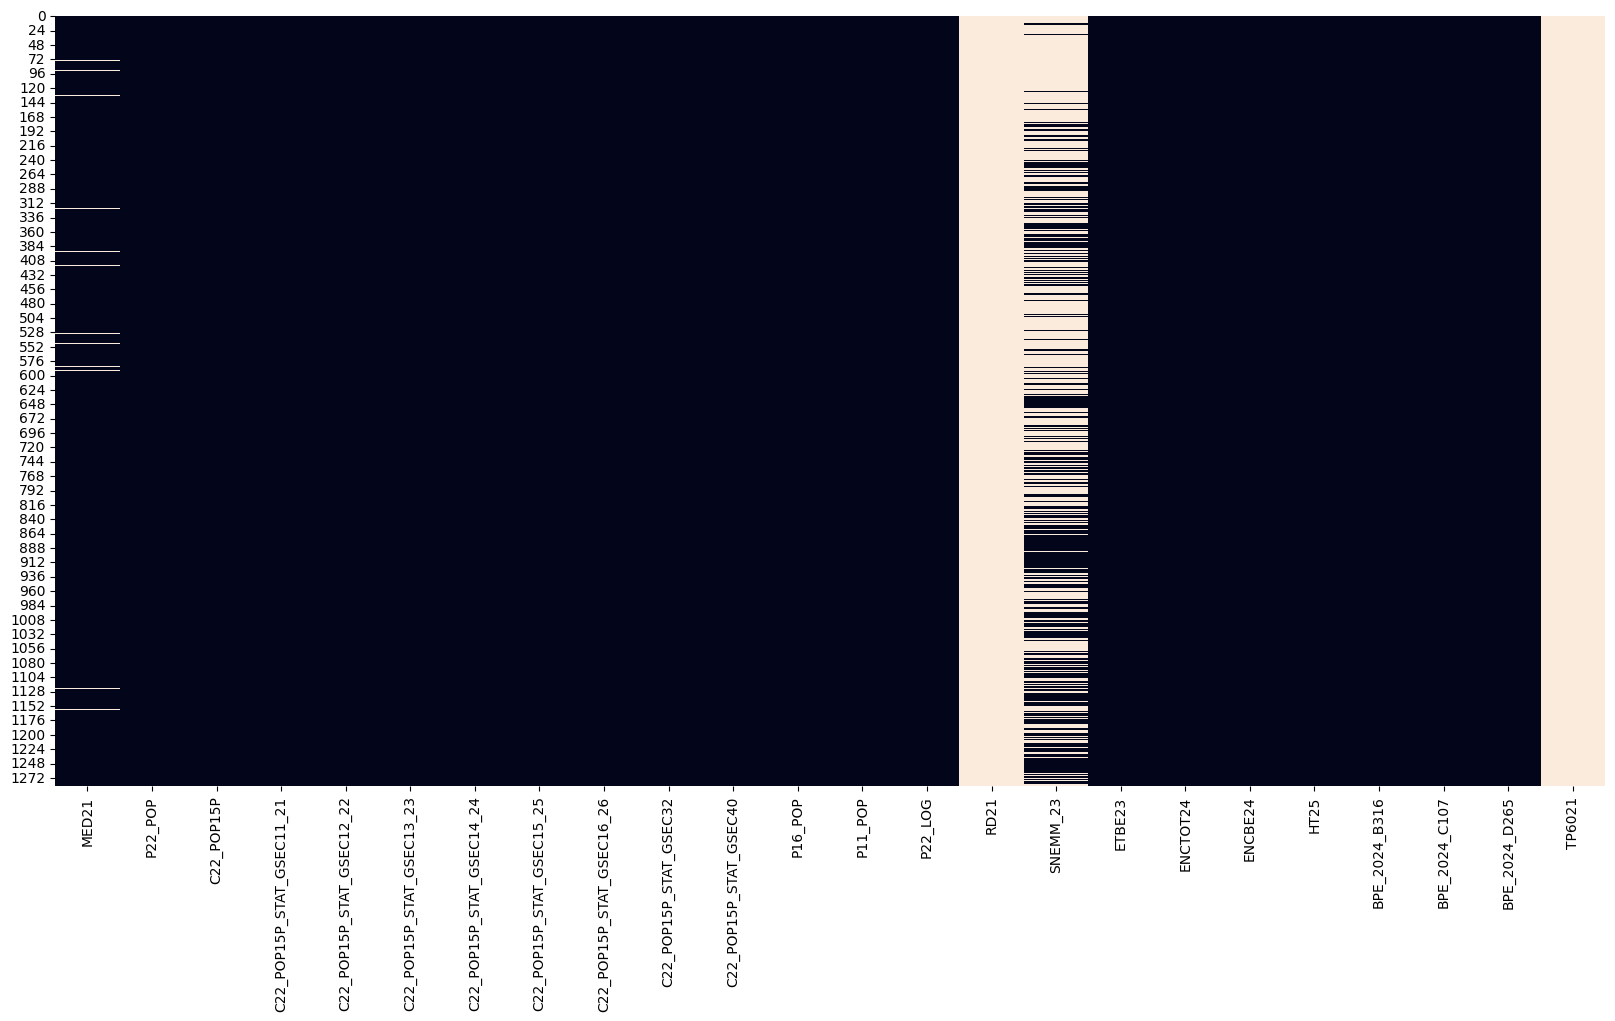

In [24]:
# On transforme les "s" (convention INSEE) en NAs (ce qu'ils signifient) - cela ne concerne que TP6021 et RD21 (les autres sont déjà des float)
communes_idf_dem["TP6021"] = pd.to_numeric(communes_idf_dem["TP6021"], errors='coerce') # la méthode coerce convertit automatiquement en NAs les caractères
communes_idf_dem["RD21"] = pd.to_numeric(communes_idf_dem["RD21"], errors='coerce')
communes_idf_dem["MED21"] = pd.to_numeric(communes_idf_dem["MED21"], errors='coerce')

# On visualise les NAs
plt.figure(figsize=(20,10))
sns.heatmap(communes_idf_dem.isna(), cbar=False)

In [25]:
# Autre façon de faire
communes_idf_dem.isna().sum()

MED21                          15
P22_POP                         1
C22_POP15P                      1
C22_POP15P_STAT_GSEC11_21       1
C22_POP15P_STAT_GSEC12_22       1
C22_POP15P_STAT_GSEC13_23       1
C22_POP15P_STAT_GSEC14_24       1
C22_POP15P_STAT_GSEC15_25       1
C22_POP15P_STAT_GSEC16_26       1
C22_POP15P_STAT_GSEC32          1
C22_POP15P_STAT_GSEC40          1
P16_POP                         1
P11_POP                         1
P22_LOG                         1
RD21                         1286
SNEMM_23                      740
ETBE23                          1
ENCTOT24                        1
ENCBE24                         1
HT25                            1
BPE_2024_B316                   1
BPE_2024_C107                   1
BPE_2024_D265                   1
TP6021                       1286
dtype: int64

In [26]:
#### On réduit, à titre provisoire, notre df total à quelques variables d'intérêt (sans TP601, RD21 ni SNEMM_23 à cause des NAs)

# On sélectionne les variables
communes_idf_short = communes_idf.copy()
communes_idf_short = communes_idf_short[[
    
    # Variables descriptives
"insee", "nom", "departement", "surf_ha", "geometry", "centroid", "x", "y",

    # Variables démographiques (dossier complet de l'insee)
"MED21", "P22_POP", "P22_ACTOCC15P", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22", "C22_POP15P_STAT_GSEC13_23",
"C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32", "C22_POP15P_STAT_GSEC40",
"P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316", "BPE_2024_C107", "BPE_2024_D265",

    # Variables liées à la pollution industrielles tirées de Géorisques
"Polluee", "rejets_isoles", "nb_etablissements_isoles", "rejets_raccordes", "nb_etablissements_raccordes", "rejets_tot", "nb_etablissements_rejets_tot",
"nombre_etablissements_emissions", "nombre_etablissements_emissions_2_plus", "nombre_etablissements_emissions_3_plus", "nombre_etablissements_dechets",
"nombre_etablissements_dechets_2_plus", "nombre_etablissements_dechets_3_plus",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10"]]

communes_idf_short.head()

insee                nom departement  surf_ha  \
0  77024         Bassevelle          77   1751.0   
1  77414     Saint-Hilliers          77   1908.0   
2  77068  Cessoy-en-Montois          77    528.0   
3  77019             Balloy          77   1338.0   
4  77286           Meigneux          77    780.0   

                                            geometry              centroid  \
0  POLYGON ((3.24 48.909, 3.24 48.91, 3.24 48.91,...  POINT (3.282 48.923)   
1  POLYGON ((3.218 48.652, 3.22 48.652, 3.221 48....  POINT (3.258 48.629)   
2  POLYGON ((3.118 48.506, 3.119 48.506, 3.119 48...  POINT (3.139 48.508)   
3  POLYGON ((3.127 48.406, 3.127 48.407, 3.127 48...  POINT (3.151 48.397)   
4  POLYGON ((3.057 48.515, 3.057 48.515, 3.057 48...  POINT (3.097 48.514)   

          x          y  MED21  P22_POP  ...  nb_etablissements_rejets_tot  \
0  3.282105  48.923252  24850    385.0  ...                           NaN   
1  3.258024  48.628932  25320    479.0  ...                           NaN   
2  3.138883  48.507759  26430    213.0  ...                           NaN   
3  3.151339  48.397092  23710    351.0  ...                           NaN   
4  3.097187  48.513537  27690    234.0  ...                           NaN   

   nombre_etablissements_emissions  nombre_etablissements_emissions_2_plus  \
0                              NaN                                     NaN   
1                              NaN                                     NaN   
2                              NaN                                     NaN   
3                              NaN                                     NaN   
4                              NaN                                     NaN   

   nombre_etablissements_emissions_3_plus  nombre_etablissements_dechets  \
0                                     NaN                            NaN   
1                                     NaN                            NaN   
2                                     NaN                            NaN   
3                                     NaN                            NaN   
4                                     NaN                            NaN   

   nombre_etablissements_dechets_2_plus  nombre_etablissements_dechets_3_plus  \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN                                   NaN   
3                                   NaN                                   NaN   
4                                   NaN                                   NaN   

   no2  o3  pm10  
0   11  35    24  
1   11  37    22  
2   11  38    19  
3   11  41    19  
4   11  39    19  

[5 rows x 46 columns]

In [27]:
# On renomme les colonnes 

communes_idf_short = communes_idf_short.rename(
    columns = {"MED21" : "revenu_median_2021",
    "P22_POP" : "population_2022",
    "C22_POP15P" : "population_15_plus",
    "P22_ACTOCC15P" : "population_active_occupee",
    "C22_POP15P_STAT_GSEC11_21" : "nombre_agriculteurs",
    "C22_POP15P_STAT_GSEC12_22" : "nombre_artisans",
    "C22_POP15P_STAT_GSEC13_23" : "nombre_cpis",
    "C22_POP15P_STAT_GSEC14_24" : "nombre_pi",
    "C22_POP15P_STAT_GSEC15_25" : "nombre_employes",
    "C22_POP15P_STAT_GSEC16_26" : "nombre_ouvriers",
    "C22_POP15P_STAT_GSEC32" : "nombre_retraites",
    "C22_POP15P_STAT_GSEC40" : "nombre_sans_activite",
    "P16_POP" : "population_2016",
    "P11_POP" : "population_2011",
    "P22_LOG" : "nombre_logements",
    "ETBE23" : "nombre_etablissements_industrie",
    "ENCTOT24" : "creations_entreprises",
    "ENCBE24" : "creations_entreprises_industrie",
    "HT25" : "nombre_hôtels_2025",
    "BPE_2024_B316" : "nombre_stations_service",
    "BPE_2024_C107" : "nombre_ecoles_maternelles",
    "BPE_2024_D265" : "nombre_medecins_generalistes"
    }
)

Pour nos analyses futures, on aura besoin de raisonner "par habitant" : par exemple, pour estimer économétriquement l'influence d'être une ville très ouvrière, en sachant qu'on contrôlera uniquement par la densité et la superficie (et non par la population pour éviter la redondance), il nous prendre en compte une variable "part d'ouvriers" plutôt que "nombre d'ouvriers".

NB : On divise ici par la population des actifs occupés et non par la population totale.

In [28]:
# On crée des variables "par habitant"
communes_idf_short["logements_habitant"] = communes_idf_short["nombre_logements"] / communes_idf_short["population_active_occupee"]
communes_idf_short["industries_habitant"] = communes_idf_short["nombre_etablissements_industrie"] / communes_idf_short["population_active_occupee"]
communes_idf_short["stations_service_habitant"] = communes_idf_short["nombre_stations_service"] / communes_idf_short["population_active_occupee"]
communes_idf_short["ecoles_maternelles_habitant"] = communes_idf_short["nombre_ecoles_maternelles"] / communes_idf_short["population_active_occupee"]
communes_idf_short["medecins_generalistes_habitant"] = communes_idf_short["nombre_medecins_generalistes"] / communes_idf_short["population_active_occupee"]
communes_idf_short["hotels_habitant"] = communes_idf_short["nombre_hôtels_2025"] / communes_idf_short["population_active_occupee"]
communes_idf_short["densite"] = communes_idf_short["population_2022"] / communes_idf_short["surf_ha"]

# Une variable pour la part de chaque CS
communes_idf_short["part_ouvriers"] = communes_idf_short["nombre_ouvriers"] / communes_idf_short["population_active_occupee"]
communes_idf_short["part_cpis"] = communes_idf_short["nombre_cpis"] / communes_idf_short["population_active_occupee"]
communes_idf_short["part_agriculteurs"] = communes_idf_short["nombre_agriculteurs"] / communes_idf_short["population_active_occupee"]
communes_idf_short["part_employes"] = communes_idf_short["nombre_employes"] / communes_idf_short["population_active_occupee"]
communes_idf_short["part_pi"] = communes_idf_short["nombre_pi"] / communes_idf_short["population_active_occupee"]
communes_idf_short["part_artisans"] = communes_idf_short["nombre_artisans"] / communes_idf_short["population_active_occupee"]
communes_idf_short["part_retraites"] = communes_idf_short["nombre_retraites"] / communes_idf_short["population_2022"]
communes_idf_short["part_sans_activite"] = communes_idf_short["nombre_sans_activite"] / communes_idf_short["population_2022"]


# Une variable, par ailleurs, pour l'évolution démographique
communes_idf_short["croissance_demographique_2011_2022"] = (communes_idf_short["population_2022"] - communes_idf_short["population_2011"]) / communes_idf_short["population_2011"]

In [29]:
## Nettoyage

# On convertit le revenu médian en numérique
communes_idf_short["revenu_median_2021"] = pd.to_numeric(communes_idf_short["revenu_median_2021"], errors = "coerce")

# On nettoie le revenu médian en supprimant les (15) lignes non renseignées
communes_idf_short = communes_idf_short.dropna(subset=['revenu_median_2021'])

# On supprime la ville de Pierrefitte (dont on a remarqué qu'elle est la seule pour laquelle P22_POP n'est pas renseignée)
communes_idf_short = communes_idf_short[communes_idf_short["insee"] != "93059"]

<Axes: >

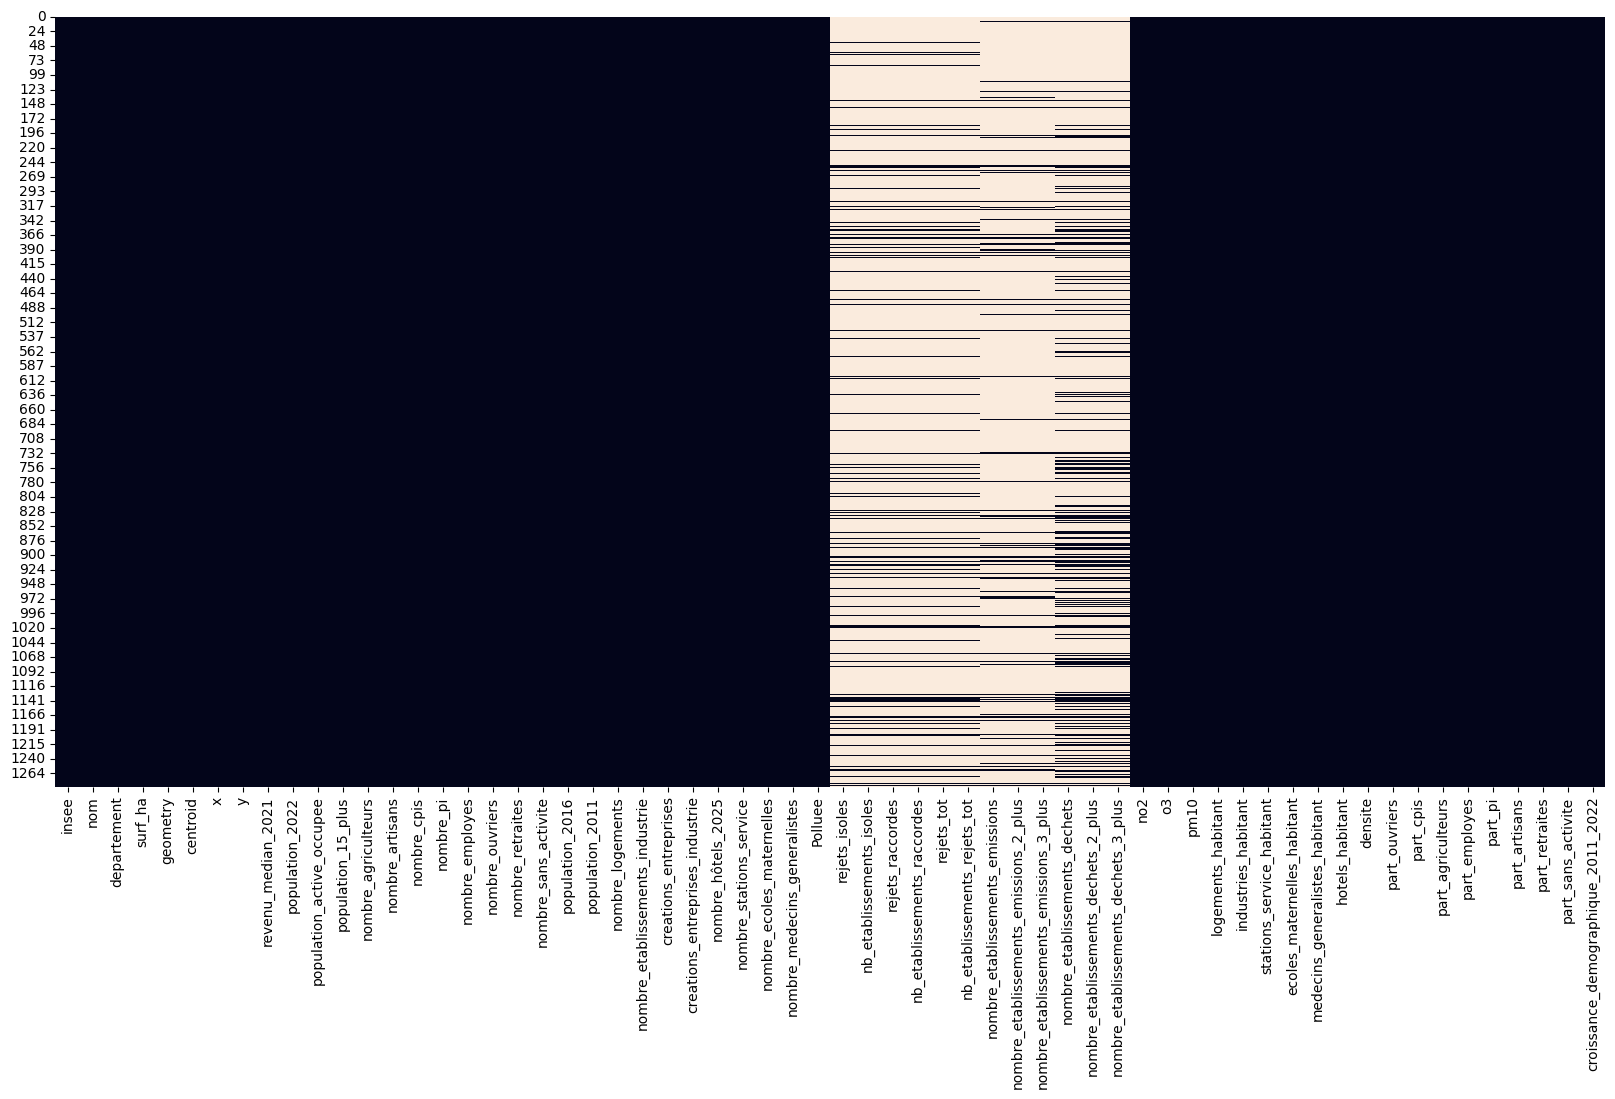

In [30]:
# On visualise les valeurs manquantes (aucune sauf pour les rejets - car NA = 0 ici)
plt.figure(figsize=(20,10))
sns.heatmap(communes_idf_short.isna(), cbar=False)

**Partie 2 : Analyses statistiques descriptives et visualisations**

*2.1. Description statistique univariée de la base*

Dans cette partie, on réalise en premier lieu une analyse statistique descriptive de la base créée, communes_idf_short.

On isole dans un premier temps les variables sociales. Elles contiennent le revenu médian en 2021 et le part d'individus de chaque catégorie socio-professionnelle (PCS) définies par l'INSEE (agriculteurs exploitants, commerçants et chefs d'entreprise, cadres et professions intellectuelles supérieures, professions intermédiaires, employés,ouvriers, retraités, personnes sans activité professionnelle).

In [31]:
variables_sociales = [
    "revenu_median_2021",
    "part_agriculteurs",
    "part_artisans",
    "part_cpis",
    "part_pi",
    "part_employes",
    "part_ouvriers",
    "part_retraites",
    "part_sans_activite"
]

Ensuite, les variables environnementales regroupent nos différents indicateurs : d'une part les rejets des industries polluantes et le nombre d'établissements concernés dans chaque commune ; et d'autre part les concentrations en pollution atmosphérique du NO2 (dioxyde d'azote), O3 (ozone), et MP10 (matières particulaires de diamètre inférieur ou égal à 10 micromètres).

In [32]:
variables_environnementales =[
'Polluee',
'rejets_isoles',
'nb_etablissements_isoles',
'rejets_raccordes',
'nb_etablissements_raccordes',
'rejets_tot',
'nb_etablissements_rejets_tot',
'nombre_etablissements_emissions',
'nombre_etablissements_emissions_2_plus',
'nombre_etablissements_emissions_3_plus',
'nombre_etablissements_dechets',
'nombre_etablissements_dechets_2_plus',
'nombre_etablissements_dechets_3_plus',
'no2',
'o3',
'pm10']

Enfin, les variables géographiques regroupent un grand nombre de variables qui nous serons utiles pour la suite de notre analyse.
Tout d'abord, on retient les variables liées aux géométries des espaces (surface avec "surf_ha") et les coordonnées géographiques ("x" et "y").

Enfin, on retient, en plus de la population et de la densité, des variables liées aux activités résidentielles (le nombre de logements en 2022 avec "nombre_logements") et économiques (nombre d'établissements industriels, nombre d'entreprises créées, nombre d'entreprises créées dans l'industrie, nombre d'hotels), et aux équipements (stations-service, écoles maternelles, médecins généralistes).

Notons que, si la prise en compte du nombre d'écoles maternelles et de médecins généralistes par habitant est a priori anodine, et n'aura au mieux qu'une portée illustrative (les communes les moins dotées sont potentiellement les plus concernées par la vulnérabilité sociale et climatique, mais ce ne serait qu'une corrélation "en plus"), nous pouvons potentiellement espérer que la densité en stations-service rende indirectement compte du trafic routier et soit donc liée à la pollution atmosphérique.

In [33]:
variables_geo_demographiques = [
    "surf_ha",
    "x",
    "y",
    "population_2022",
    "densite",
    "logements_habitant",
    "industries_habitant",
    "hotels_habitant",
    "stations_service_habitant",
    "ecoles_maternelles_habitant",
    "medecins_generalistes_habitant"
]

Après avoir isolé nos types de variables, on écrit une fonction pour afficher, à chaque fois, les statistiques descriptives associées.

In [34]:
# Cette fonction prend un argument un tableau et une liste de variables et, affiche, pour les variables correspondantes dans le tableau, la moyenne, la médiane...
def stats_descriptives(df, variables):
    return (
        df[variables]
        .describe()
        .T
        [["mean", "std", "min", "25%", "50%", "75%", "max"]]
    )

In [35]:
# On affiche la description des variables sociales
stats_descriptives(communes_idf_short, variables_sociales)

mean          std           min           25%  \
revenu_median_2021  27443.944882  4359.474175  14790.000000  24902.500000   
part_agriculteurs       0.009472     0.022799      0.000000      0.000000   
part_artisans           0.075040     0.045680      0.000000      0.047514   
part_cpis               0.254899     0.135101      0.000000      0.159057   
part_pi                 0.308910     0.068981      0.059960      0.267346   
part_employes           0.271883     0.086609      0.000000      0.214338   
part_ouvriers           0.166013     0.086460      0.000000      0.101754   
part_retraites          0.190699     0.058428      0.025641      0.152728   
part_sans_activite      0.113169     0.039095      0.000000      0.089396   

                             50%           75%           max  
revenu_median_2021  27205.000000  29637.500000  48010.000000  
part_agriculteurs       0.000000      0.006824      0.211404  
part_artisans           0.064702      0.092650      0.553672  
part_cpis               0.228385      0.324659      0.777778  
part_pi                 0.308954      0.348496      0.593567  
part_employes           0.271616      0.327211      0.599264  
part_ouvriers           0.154400      0.214934      0.550437  
part_retraites          0.185056      0.222603      0.487727  
part_sans_activite      0.110812      0.132771      0.453126

En analysant les indicateurs concernant les variables sociales des communes en Ile-de-France, on peut voir que la moyenne du revenu médian annuel des communes s'élève à 27 444 euros. Mais les écarts sont grands entre les communes, puisque le revenu médian minimal est de 14 790 euros tandis que le maximum est de 48 010 euros. Cela souligne la forte hétérogénéité socio-économique entre les communes d'Ile-de-France, ce qui pourra être intéressant dans la suite de notre analyse pour voir si les territoires les plus vulnérables socialement (les moins "riches" par exemple) sont également vulnérables du point de vue de l'exposition aux pollutions.

Concernant la structure socioprofessionnelle, les agriculteurs et artisans représentent une population minoritaire. Le groupe des cadres et professions intellectuelles supérieures est fortement polarisé, avec une moyenne de 25% par commune, mais un maximum à 77%. Cela traduit une concentration géographique des emplois qualifiés dans les grandes villes.

De même, la présence des employés et ouvriers est très inégale selon les communes : la moyenne des employés est de 27% mais ce chiffre s'élève à 60% pour le maximum. 

On représente graphiquement la répartition du revenu médian dans les communes d'Ile-de-France.

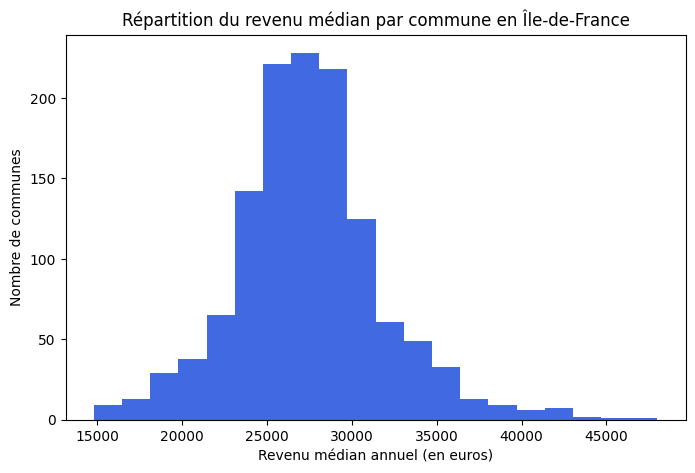

In [36]:
plt.figure(figsize=(8, 5))
plt.hist(communes_idf_short["revenu_median_2021"], bins=20, color = "royalblue")
plt.xlabel("Revenu médian annuel (en euros)")
plt.ylabel("Nombre de communes")
plt.title("Répartition du revenu médian par commune en Île-de-France")
plt.show()

Ce graphique confirme la forte hétérogénéité des niveaux de revenu, avec une majorité de communes concentrées autour de valeurs intermédiaires et une queue qui s'allonge à droite, qui correspond à un nombre plus restreint de communes très aisées. Cette dispersion reflète les inégalités socio-économiques marquées en Ile-de-France, opposant notamment certaines communes périurbaines ou rurales à des communes urbaines plus favorisées.

Le boxplot ci-dessous illustre bien la dispersion et la présence de communes très riches parmi les valeurs extrêmes, en haut de la répartition des revenus.

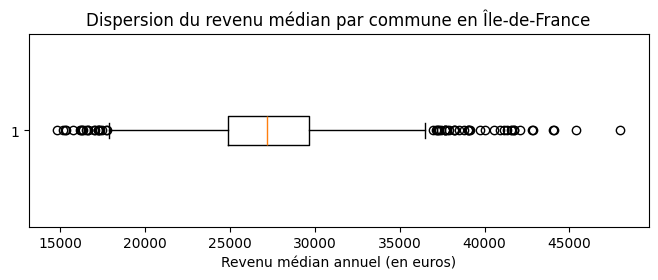

In [37]:
plt.figure(figsize=(8, 2.5))
plt.boxplot(communes_idf_short["revenu_median_2021"], vert=False)
plt.xlabel("Revenu médian annuel (en euros)")
plt.title("Dispersion du revenu médian par commune en Île-de-France")
plt.show()

On fait de même l'analyse statistique descriptive des variables géographiques.

In [38]:
stats_descriptives(communes_idf_short, variables_geo_demographiques)

mean           std         min  \
surf_ha                          942.959273    794.820383    9.000000   
x                                  2.434051      0.470198    1.480795   
y                                 48.762433      0.242064   48.140585   
population_2022                 9748.026772  21765.387123  102.000000   
densite                           17.854614     42.358460    0.105383   
logements_habitant                 0.998837      0.170022    0.515337   
industries_habitant                0.003602      0.004363    0.000000   
hotels_habitant                    0.000266      0.001209    0.000000   
stations_service_habitant          0.000222      0.000788    0.000000   
ecoles_maternelles_habitant        0.000494      0.001049    0.000000   
medecins_generalistes_habitant     0.000929      0.002723    0.000000   

                                       25%          50%          75%  \
surf_ha                         481.000000   777.000000  1185.750000   
x                                 2.077220     2.402457     2.790192   
y                                48.577877    48.805598    48.955129   
population_2022                 584.000000  1513.500000  7625.500000   
densite                           0.635877     1.821552    12.577162   
logements_habitant                0.893751     0.975864     1.068858   
industries_habitant               0.000000     0.002516     0.004741   
hotels_habitant                   0.000000     0.000000     0.000000   
stations_service_habitant         0.000000     0.000000     0.000163   
ecoles_maternelles_habitant       0.000000     0.000000     0.000651   
medecins_generalistes_habitant    0.000000     0.000000     0.001361   

                                          max  
surf_ha                          17260.000000  
x                                    3.489394  
y                                   49.213240  
population_2022                 228754.000000  
densite                            381.899419  
logements_habitant                   2.309658  
industries_habitant                  0.044900  
hotels_habitant                      0.019364  
stations_service_habitant            0.016459  
ecoles_maternelles_habitant          0.014286  
medecins_generalistes_habitant       0.083152

Concernant la structure spatiale des communes d'Ile-de-France, on voit que la superficie moyenne des communes est d’environ 943 hectares, mais cette moyenne masque une forte hétérogénéité territoriale. Le premier quartile se situe à 481 hectares, tandis que le troisième atteint 1186 hectares, ce qui indique que la majorité des communes ont une superficie relativement petite. 

Cette dispersion reflète l’opposition entre les communes rurales ou périurbaines très étendues et les communes urbaines plus petites, particulièrement présentes dans la petite couronne. C'est ce qu'on peut voir dans l'histogramme suivant, avec une forte concentration de petites communes (faibles superficies), mais avec une queue qui s'étend à droite, indiquant la présence (mais faible) de grandes communes.


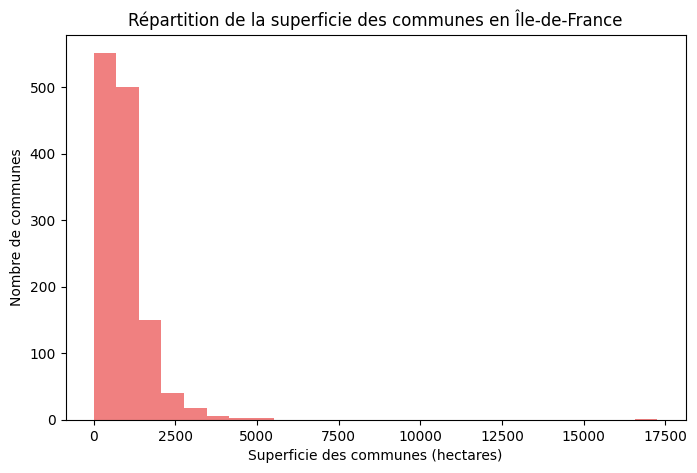

In [39]:
plt.figure(figsize=(8, 5))
plt.hist(communes_idf_short["surf_ha"], bins=25, color = "lightcoral")
plt.xlabel("Superficie des communes (hectares)")
plt.ylabel("Nombre de communes")
plt.title("Répartition de la superficie des communes en Île-de-France")
plt.show()

Ainsi, on affiche un graphique avec une échelle logarithmique pour mieux observer la répartition de la superficie des petites communes.

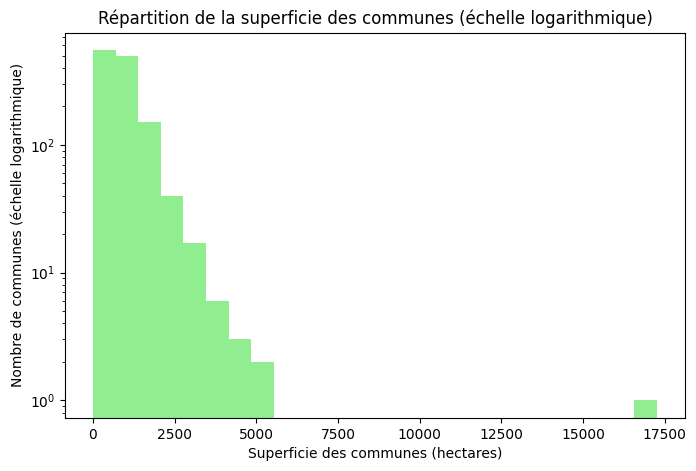

In [40]:
plt.figure(figsize=(8, 5))
plt.hist(communes_idf_short["surf_ha"], bins=25, color = "lightgreen")
plt.yscale("log")
plt.xlabel("Superficie des communes (hectares)")
plt.ylabel("Nombre de communes (échelle logarithmique)")
plt.title("Répartition de la superficie des communes (échelle logarithmique)")
plt.show()


Concernant les variables démographiques, on remarque que les communes d’Île-de-France présentent une distribution très asymétrique de leur population. En effet, la population moyenne en 2022 est d’environ 9 748 habitants, mais la médiane n’est que de 1 514 habitants, indiquant que la majorité des communes sont de petite taille. Cette asymétrie est confirmée par la valeur maximale qui dépasse 228 000 habitants, correspondant aux grandes villes de la région et par la médiane du nombre de logements par commune (666), très éloignée de la moyenne (4 781).

Concernant l'évolution démographique, les populations de 2011, 2016 et 2022 sont très proches en moyenne, ce qui suggère une relative stabilité démographique à l’échelle régionale.


/tmp/ipykernel_67109/2612156003.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


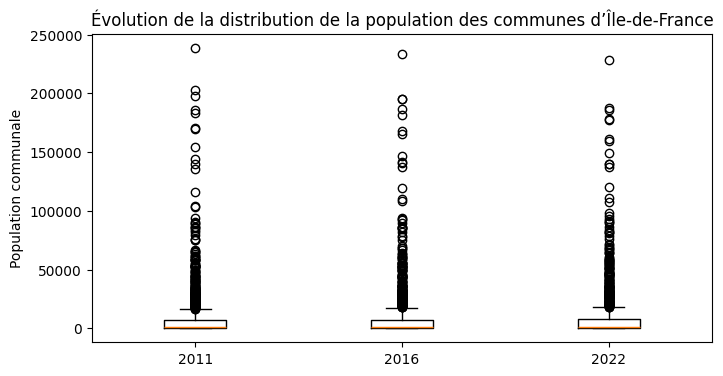

In [41]:
# construction de boxplot de la répartition démographique à travers le temps

plt.figure(figsize=(8, 4))
plt.boxplot(
    [communes_idf_short["population_2011"],
    communes_idf_short["population_2016"],
    communes_idf_short["population_2022"]],
    labels=["2011", "2016", "2022"],
    showfliers=True
)

plt.ylabel("Population communale")
plt.title("Évolution de la distribution de la population des communes d’Île-de-France")

plt.show()

Sur les boxplots ci-dessus, on voit qu'à chaque date, la distribution est fortement asymétrique, avec une majorité de petites communes et quelques communes très peuplées qui tirent la distribution vers le haut. Le graphique confirme également que la population est stable, ce qui était attendu

De même, la densité moyenne est de 17,9 habitants par hectare, mais la médiane est plus faible (1,82 habitants/hectare), révélant une forte polarisation spatiale. Ainsi, certaines communes très peu denses coexistent avec des communes extrêmement denses, atteignant près de 382 habitants/hectares. Cela pourra être pertinent pour la suite de notre analyse, pour lier cette variable de densité, reflet de l'urbanisation, aux concentrations atmosphériques de pollution.

C'est ce que l'on voit avec la présence de valeurs extrêmes à droite du boxplot, qui représentent des communes très denses.

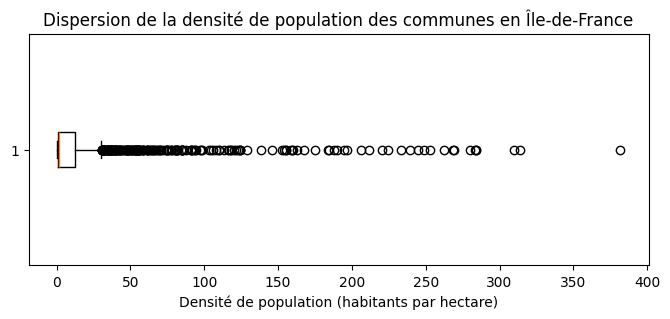

In [42]:
# boxplot concernant la répartition de la densité des communes en Ile-de-France
plt.figure(figsize=(8, 3))
plt.boxplot(communes_idf_short["densite"], vert=False)
plt.xlabel("Densité de population (habitants par hectare)")
plt.title("Dispersion de la densité de population des communes en Île-de-France")
plt.show()


Cette dispersion territoriale s'observe également à travers les variables liées à l’activité économique. En effet, le nombre moyen d’établissements industriels est faible (15), avec une médiane de 2, ce qui suggère que l’industrie est très concentrée spatialement. De même, les créations d’entreprises suivent une logique similaire avec une médiane de 22 créations seulement, mais un maximum supérieur à 20 000, ce qui est caractéristique des grandes communes urbaines. Cela capture une polarisation économique de la région autour de quelques pôles majeurs.

Ainsi, l’analyse descriptive des variables géographiques met en évidence l'hétérogénéité caractéristique de la région Île-de-France, marquée par une forte polarisation entre communes rurales peu peuplées et communes urbaines très denses. La taille, la densité et la localisation géographique des communes apparaissent comme des déterminants majeurs de leur structure sociale, ce qui justifiera l’introduction de ces variables spatiales dans nos modèles économétriques afin de mieux capturer les effets territoriaux à l’œuvre.

On va utiliser des outils cartographiques pour faire l'analyse de la répartition territoriale des variables environnementales, liées aux pollutions.

*2.2. Exploration de la cartographie des pollutions*

On commence par afficher les statistiques descriptives des variables environnementales.

In [43]:
stats_descriptives(communes_idf_short, variables_environnementales)

mean           std   min  \
rejets_isoles                           6.854453e+06  4.208004e+07   0.0   
nb_etablissements_isoles                6.562500e-01  7.774080e-01   0.0   
rejets_raccordes                        3.098472e+05  1.820793e+06   0.0   
nb_etablissements_raccordes             1.168750e+00  1.094422e+00   0.0   
rejets_tot                              7.164300e+06  4.216850e+07   0.0   
nb_etablissements_rejets_tot            1.825000e+00  1.389765e+00   1.0   
nombre_etablissements_emissions         1.341463e+00  6.874671e-01   1.0   
nombre_etablissements_emissions_2_plus  9.186992e-01  7.530647e-01   0.0   
nombre_etablissements_emissions_3_plus  5.447154e-01  6.560192e-01   0.0   
nombre_etablissements_dechets           2.187075e+00  2.335883e+00   1.0   
nombre_etablissements_dechets_2_plus    2.030612e+00  2.251071e+00   0.0   
nombre_etablissements_dechets_3_plus    1.833333e+00  2.107061e+00   0.0   
no2                                     1.708661e+01  7.452633e+00   5.0   
o3                                      3.699213e+01  2.949258e+00  30.0   
pm10                                    2.071732e+01  3.687510e+00  14.0   

                                           25%      50%        75%  \
rejets_isoles                              0.0      0.0   38316.00   
nb_etablissements_isoles                   0.0      1.0       1.00   
rejets_raccordes                           0.0   6832.0   51685.25   
nb_etablissements_raccordes                1.0      1.0       1.00   
rejets_tot                              5134.5  34788.5  225588.25   
nb_etablissements_rejets_tot               1.0      1.0       2.00   
nombre_etablissements_emissions            1.0      1.0       1.00   
nombre_etablissements_emissions_2_plus     0.0      1.0       1.00   
nombre_etablissements_emissions_3_plus     0.0      0.0       1.00   
nombre_etablissements_dechets              1.0      1.0       2.00   
nombre_etablissements_dechets_2_plus       1.0      1.0       2.00   
nombre_etablissements_dechets_3_plus       1.0      1.0       2.00   
no2                                       11.0     15.0      22.00   
o3                                        35.0     37.0      40.00   
pm10                                      19.0     20.0      24.00   

                                                max  
rejets_isoles                           481041523.0  
nb_etablissements_isoles                        4.0  
rejets_raccordes                         17708955.0  
nb_etablissements_raccordes                     8.0  
rejets_tot                              481041523.0  
nb_etablissements_rejets_tot                    9.0  
nombre_etablissements_emissions                 4.0  
nombre_etablissements_emissions_2_plus          4.0  
nombre_etablissements_emissions_3_plus          3.0  
nombre_etablissements_dechets                  23.0  
nombre_etablissements_dechets_2_plus           22.0  
nombre_etablissements_dechets_3_plus           20.0  
no2                                            42.0  
o3                                             43.0  
pm10                                           29.0

A travers ces indicateurs, on fait le constat que les niveaux de rejets industriels sont très contrastés selon les communes. Les moyennes de rejets (isolés, raccordés, totaux) sont élevées (environ 7,2 millions pour les rejets totaux), mais les médianes sont très faibles (34 789 pour les rejets totaux). Cela signifie que la majorité des communes rejettent peu ou pas de polluants, tandis que quelques communes concentrent l'essentiel des rejets, ce qui tire la moyenne vers le haut. 

Cela souligne la concentration spatiale extrême des nuisances industrielles, avec quelques communes qui abritent des sites industriels majeurs. Donc la pollution est loin d'être diffuse, mais est localisée dans certains espaces en particulier.

C'est ce qu'on observe sur le graphique suivant : quelques communes rejettent une quantité élevée de polluants, étirant la queue du graphique vers la droite.

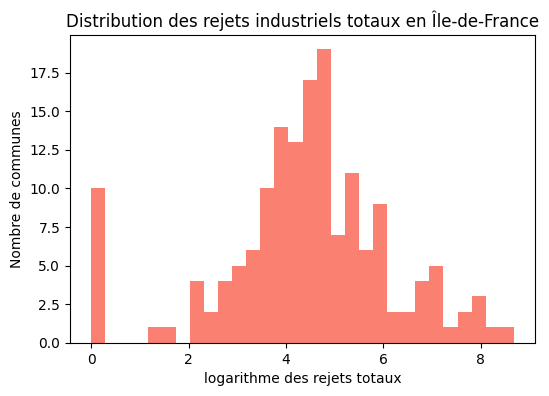

In [44]:
plt.figure(figsize=(6, 4))
plt.hist(np.log10(communes_idf_short["rejets_tot"] + 1), bins=30, color ="salmon") # on affiche avec une échelle logarithmique
plt.xlabel("logarithme des rejets totaux")
plt.ylabel("Nombre de communes")
plt.title("Distribution des rejets industriels totaux en Île-de-France")
plt.show()

Parmi les polluants atmosphériques, on voit que le NO2 est le polluant le plus discriminant spatialement, puisque son écart-type est d'environ 7 unités, avec une moyenne de 17 µg/m³ alors que son maximum atteint 42 µg/m³. Ce gaz est en effet fortement lié aux axes de transport et zones industrielles et denses.

On observe ci-dessous la forme de sa distribution avant celle de l'O3 et des PM10.

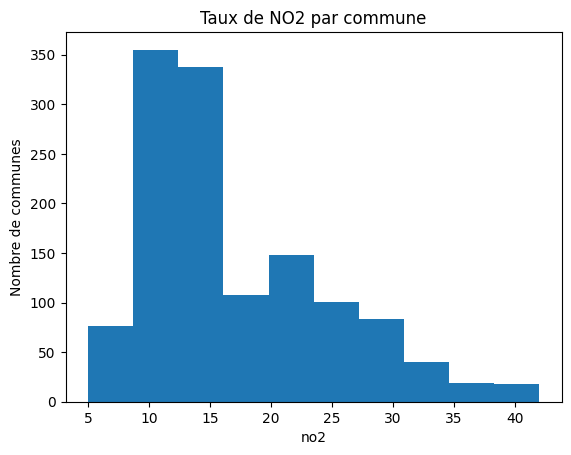

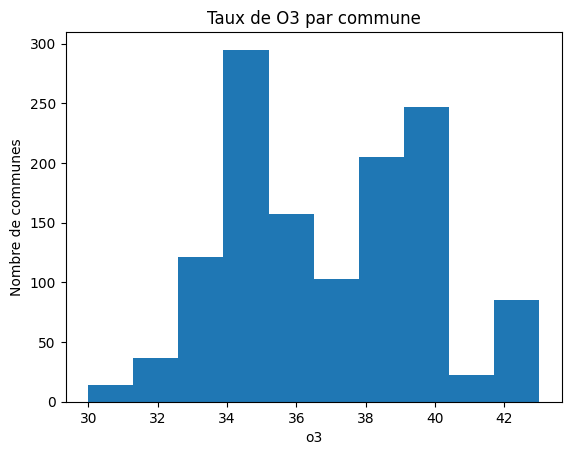

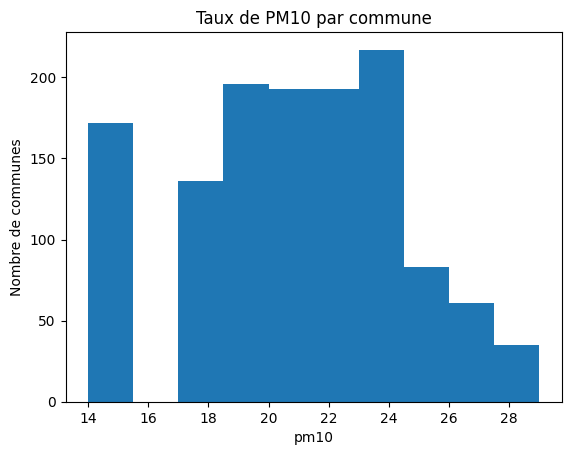

In [45]:
# NO2
plt.hist(communes_idf["no2"])
plt.xlabel("no2")
plt.ylabel("Nombre de communes")
plt.title("Taux de NO2 par commune")
plt.show()

# O3
plt.hist(communes_idf["o3"])
plt.xlabel("o3")
plt.ylabel("Nombre de communes")
plt.title("Taux de O3 par commune")
plt.show()

# PM10
plt.hist(communes_idf["pm10"])
plt.xlabel("pm10")
plt.ylabel("Nombre de communes")
plt.title("Taux de PM10 par commune")
plt.show()

On visualise les différentes concentrations atmosphériques à travers des cartes de la région Ile-de-France, colorées différemment selon la concentration de NO2, O3 et PM10.

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

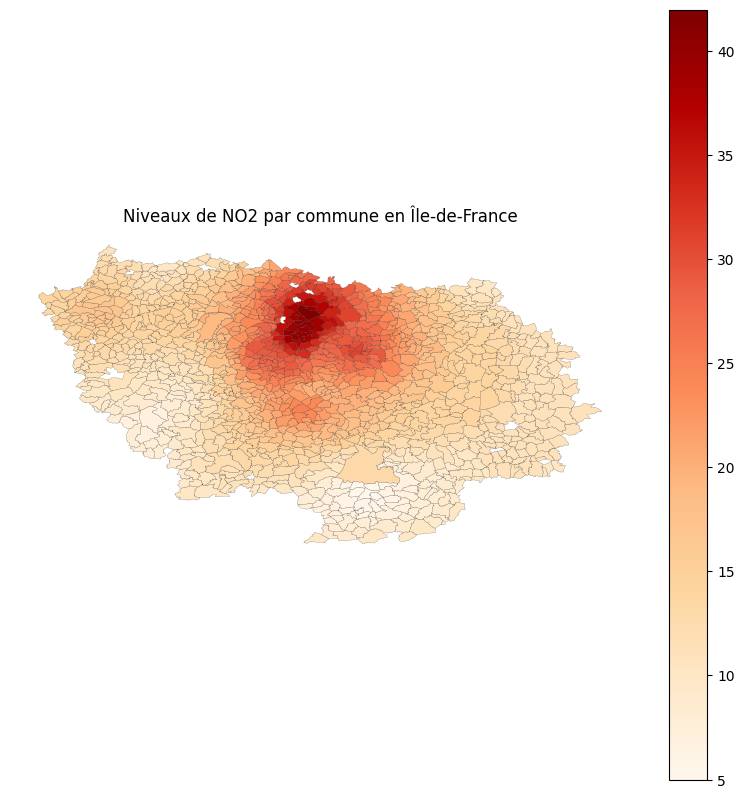

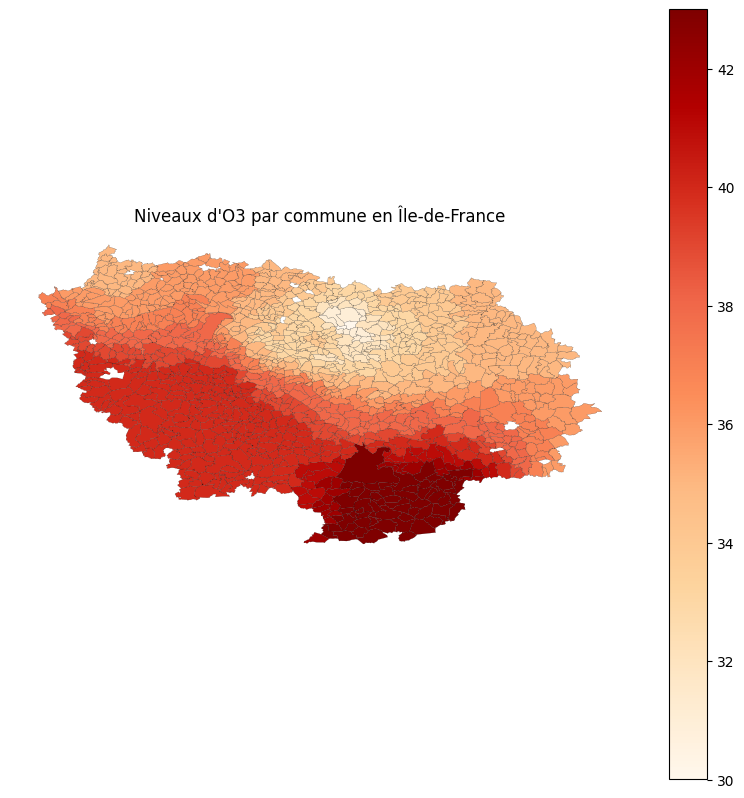

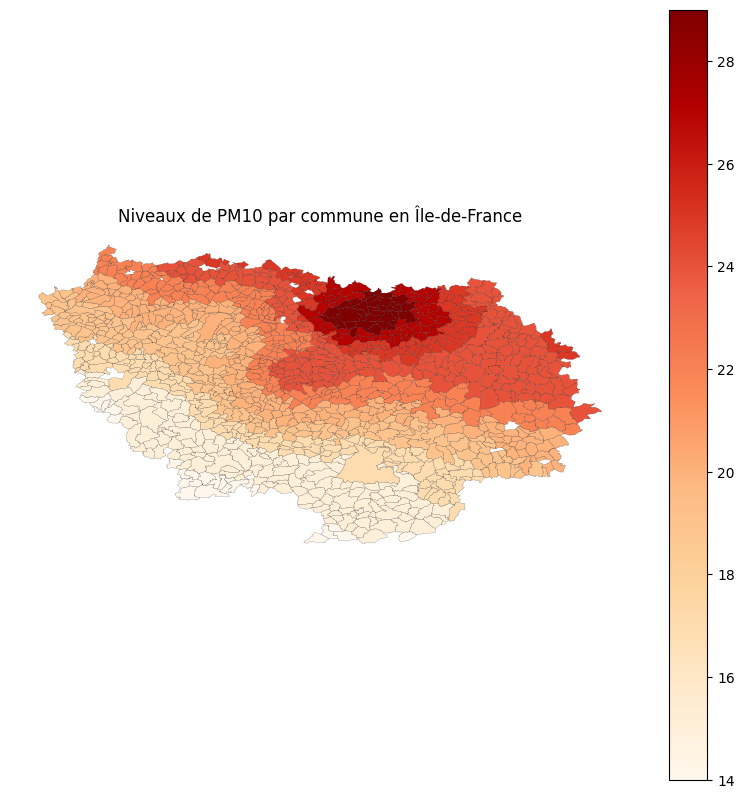

In [46]:
# NO2
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="no2",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux de NO2 par commune en Île-de-France")
ax.axis("off")

# 03
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="o3",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux d'O3 par commune en Île-de-France")
ax.axis("off")

# PM10
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="pm10",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux de PM10 par commune en Île-de-France")
ax.axis("off")

A travers ces trois cartes, nous pouvons faire plusieurs observations.
Tout d'abord, les niveaux de NO2, 03 et PM10 sont répartis de manière hétérogène en Ile-de-France. L'ozone (O3) est par exemple plus présent dans le sud et le sud-est de la région, tandis que le dioxyde d'azote (NO2) se concentre majoritairement au nord de Paris, vers la Seine-Saint-Denis (plus de 40 µg/m³), et les matières particulaires (PM10) sont graduellement plus présentes vers le sud - sud-est, en particulier autour du hub aéroportuaire de Roissy-Charles de Gaulle. Ces différences peuvent être liées à des facteurs climatiques (sens des vents pour le PM10), géographiques (présence de monoxyde d'azote (NO) qui dégrade l'ozone dans les régions plus urbaines du nord) et sociaux.

Avant de passer aux régressions et d'évaluer les liens linéaires entre ces concentrations et nos facteurs sociaux, nous pouvons voir que les concentrations en NO2 et en PM10 sont plus élevées dans des espaces globalement moins aisés, en particulier la Seine-Saint-Denis, qui présente un trafic routier important et possède des zones industrielles et portuaires. Nous pouvons ainsi supposer, à titre provisoire pour l'instant, l'existence d'une corrélation entre vulnérabilités sociale et environnementale dans ce cas. Néanmoins, celle-ci peut être nuancée puisque la concentration en ozone est tout de même plus élevée dans le sud de l'Ile-de-France, comprenant notamment les Hauts-de-Seine, les Yvelines et l'Essonne, qui comportent plusieurs communes où la moyenne des revenus est nettement plus élevée que la moyenne régionale.

On visualise de même les rejets industriels, peu représentés - et dont on ne peut pas, par conséquent, dire grand chose.

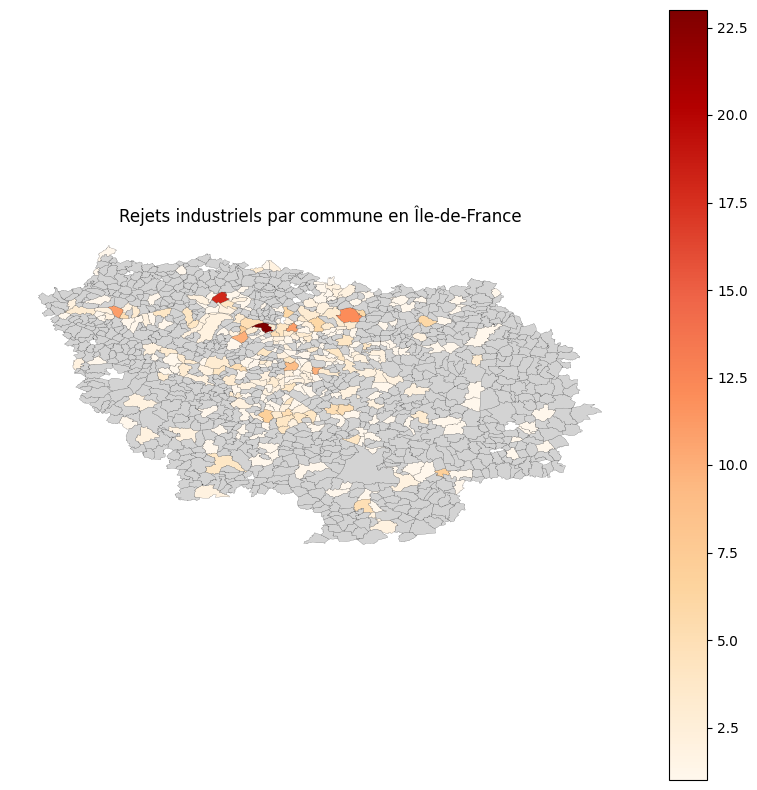

In [47]:
# Rejets

fig, ax = plt.subplots(figsize=(10, 10))

communes_idf_short.plot(
    column="nombre_etablissements_dechets",
    cmap="OrRd",
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.1,
    missing_kwds={
        "color": "lightgrey",
        "label": "Donnée manquante"
    }
)

ax.set_title("Rejets industriels par commune en Île-de-France")
ax.axis("off")
plt.show()

A présent, on va chercher à créer un "score" synthétique de pollution de l'air. Avec le peu d'informations dont nous disposons (en partie car nous nous sommes restreints dans le cadre de cet exercice), il nous est impossible de reproduire des méthodologies utilisées pour d'autres contextes (par exemple des comparaisons internationales). Basiquement, nous proposons donc de "découper" chaque indicateur en quintiles et de faire une moyenne simple de ces trois scores - ce qui revient à faire une moyenne après standardisation, quoique cela crée des "trous" en discrétisant le score. 

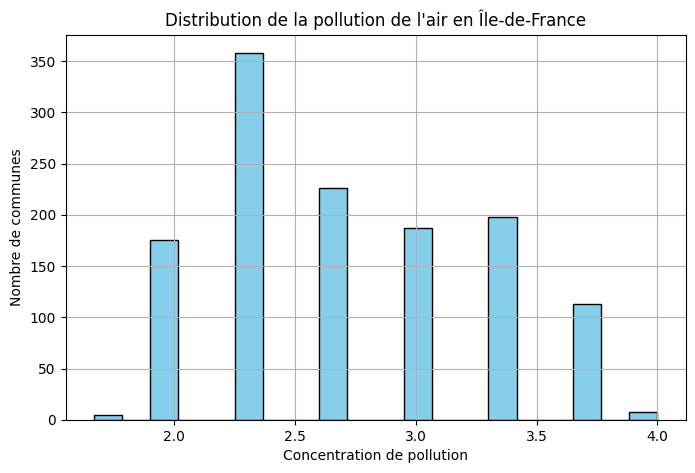

In [48]:
## On crée des quintiles

# PM10
communes_idf_short["quintile_pm10"] = pd.qcut(
    communes_idf_short["pm10"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# 03
communes_idf_short["quintile_o3"] = pd.qcut(
    communes_idf_short["o3"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# N02
communes_idf_short["quintile_no2"] = pd.qcut(
    communes_idf_short["no2"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# On convertit les catégories en numériques
communes_idf_short["quintile_pm10"] = pd.to_numeric(communes_idf_short["quintile_pm10"])
communes_idf_short["quintile_o3"] = pd.to_numeric(communes_idf_short["quintile_o3"])
communes_idf_short["quintile_no2"] = pd.to_numeric(communes_idf_short["quintile_no2"])

# On crée un score (moyenne)
communes_idf_short["pollution_air"] = (
    communes_idf_short[["quintile_pm10", "quintile_o3", "quintile_no2"]]
    .mean(axis=1)
)

# On observe sa distribution
communes_idf_short["pollution_air"].hist(
    bins=20,
    figsize=(8, 5),         
    color="skyblue",         
    edgecolor="black"        
)
plt.title("Distribution de la pollution de l'air en Île-de-France")
plt.xlabel("Concentration de pollution")
plt.ylabel("Nombre de communes")
plt.show()

Ce score est certes grossier, mais on peut d'ores et déjà regarder quelles villes sont "au sommet" de la liste triée par ordre décroissant - ou, dit autrement, en queue (droite) de distribution. 

*2.3. Lien pollution / conditions sociales : premiers essais*

On veut voir si les communes très polluées (respectivement peu polluées) ont des conditions sociales spécifiques. Pour cela, on crée un sous-dataframe avec seulement les communes qui ont un fort score de pollution de l'air (supérieur strictement à 3) et qui ont au moins une usine polluante (un rejet, une émission, un déchet dangereux émis...). On crée un autre dataframe complémentaire. 

In [49]:
communes_idf_echantillon_1 = communes_idf_short.loc[
    (communes_idf_short["pollution_air"] > 3) &
    (communes_idf_short["Polluee"] == True),
    "revenu_median_2021"
].dropna()

communes_idf_echantillon_2 = communes_idf_short.loc[
    ~(
        (communes_idf_short["pollution_air"] <= 3) &
        (communes_idf_short["Polluee"] == False)
    ),
    "revenu_median_2021"
].dropna()

On regarde si la différence dans la moyenne de revenu médian est significative entre les deux groupes

In [50]:
# On affiche les deux moyennes
print(communes_idf_echantillon_1.mean(), communes_idf_echantillon_2.mean())

# On fait un test de Student
print(ttest_ind(communes_idf_echantillon_1, communes_idf_echantillon_2, equal_var=False))

# On réalise un test de Cohen
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx-1)*x.var() + (ny-1)*y.var()) / (nx + ny - 2))
    return (x.mean() - y.mean()) / pooled_std
print(cohens_d(communes_idf_echantillon_1, communes_idf_echantillon_2))

24583.30827067669 26092.295409181635
TtestResult(statistic=np.float64(-3.537862991874419), pvalue=np.float64(0.0004986624875754319), df=np.float64(205.4654202920559))
-0.3477428831265079


En somme, le fait d'appartenir au groupe des communes très polluées est très significatif, mais faible. Cela est normal car on a construit une catégorie discrète alors que les effets sont continus. Cela confirme cependant l'intuition donnée par les cartes : les communes poly-exposées aux pollutions sont tendanciellement plus pauvres que les autres de la région. 

On peut visualiser la différence entre les deux moyennes comme ci-dessous.

/tmp/ipykernel_67109/2854262653.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([communes_idf_echantillon_1, communes_idf_echantillon_2], labels=["Communes très polluées", "Communes moins polluées"])


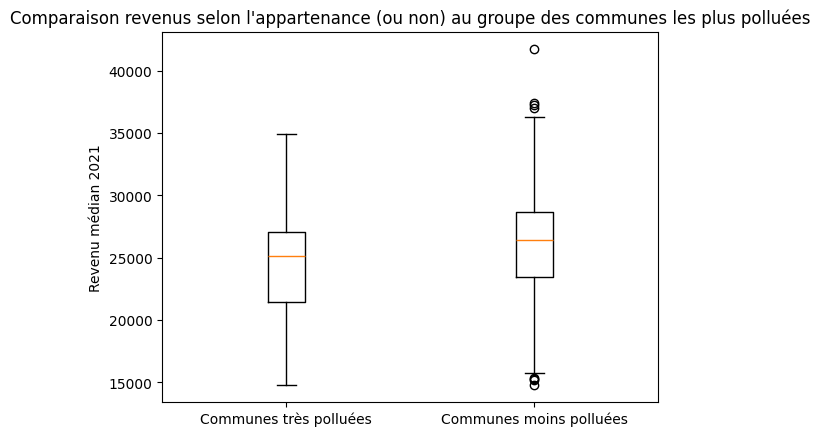

In [51]:
plt.boxplot([communes_idf_echantillon_1, communes_idf_echantillon_2], labels=["Communes très polluées", "Communes moins polluées"])
plt.ylabel("Revenu médian 2021")
plt.title("Comparaison revenus selon l'appartenance (ou non) au groupe des communes les plus polluées")
plt.show()

On peut maintenant utiliser notre score pour visualiser la pollution atmosphérique "globale" de la région et représenter de façon "croisée" les pollutions atmosphérique et industrielle, comme ci-dessous. On voit que les villes qui comportent des activités industrielles nettement polluantes sont distribuées dans toute la région, quoique davantage, semble-t-il, dans les "zones rouges" de forte pollution atmosphérique et voisines de Paris. 

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

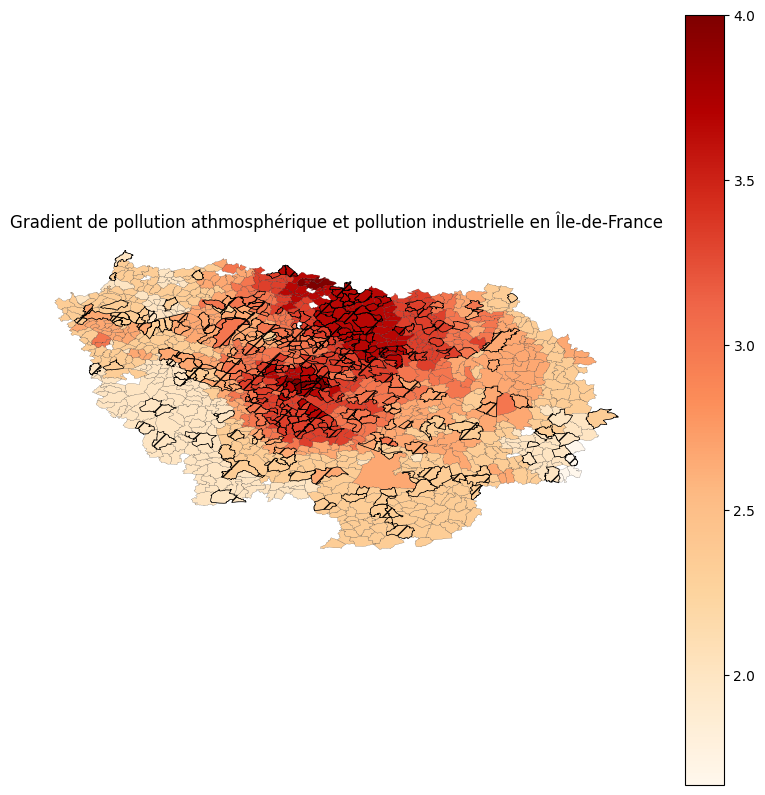

In [52]:
## Pollution air et pollution industrielle

fig, ax = plt.subplots(figsize=(10, 10))

communes_idf_short.plot(
    column="pollution_air",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

communes_idf_short[
    communes_idf_short["Polluee"]].plot(
    facecolor="none",
    hatch="/",
    linewidth=0.5,
    ax=ax
)

ax.set_title("Gradient de pollution athmosphérique et pollution industrielle en Île-de-France")
ax.axis("off")

On restreint les hachures aux communes qui ont au moins un établissement industriel qui est à la source d'au moins deux émissions toxiques. La répartition n'est toujours pas très claire, mais les villes à faible pollution atmosphérique semblent ne pas être concernées ici. 

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

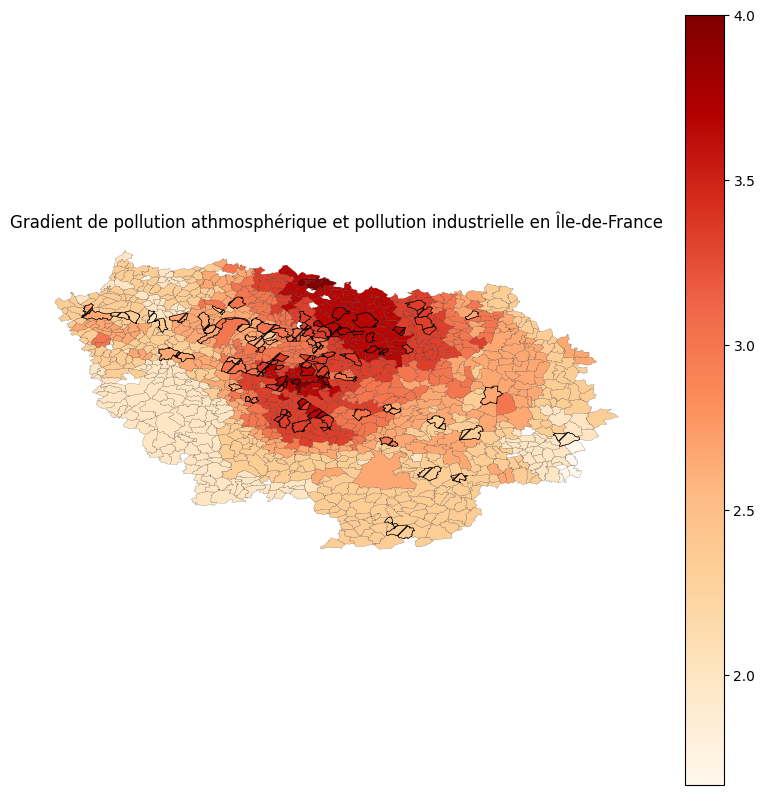

In [53]:
## Pollution air et pollution industrielle - plus fin

fig, ax = plt.subplots(figsize=(10, 10))

communes_idf_short.plot(
    column="pollution_air",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

communes_idf_short[
    communes_idf_short["nombre_etablissements_emissions_2_plus"] >= 1
].plot(
    facecolor="none",
    hatch="/",
    linewidth=0.5,
    ax=ax
)

ax.set_title("Gradient de pollution athmosphérique et pollution industrielle en Île-de-France")
ax.axis("off")


A titre d'illustration, on représente la distribution des revenus médians à travers la région : on remarque que les zones blanches sont géographiquement très proches des zones rouges foncés sur la carte précédente - autrement dit, que les zones les plus pauvres semblent les plus polluées...

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

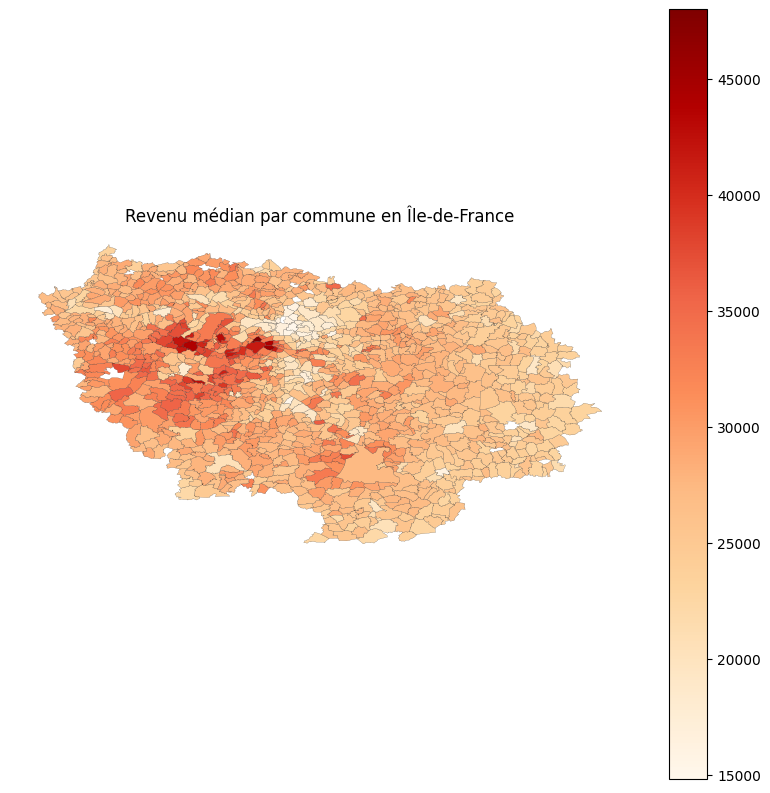

In [54]:
# Revenu médian

communes_idf_short["revenu_median_2021"] = communes_idf_short["revenu_median_2021"].astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="revenu_median_2021",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Revenu médian par commune en Île-de-France")
ax.axis("off")

*2.4. Conditions sociales et pollution : renversement de perspective*

Avant de passer à la modélisation, on propose une dernière analyse élémentaire du rapport entre pollution et niveau de vie, en créant à nouveau deux groupes extrêmes mais en termes de revenu cette fois. L'idée est de voir si les communes les plus riches se distinguent des communes les plus pauvres par leur niveau de pollution.

In [55]:
# On ajoute une colonne pour distinguer "bas / haut" en termes de revenu médian (1er et 10e déciles)
communes_idf_short["groupe_revenu"] = None
communes_idf_short.loc[communes_idf_short["revenu_median_2021"] < communes_idf_short["revenu_median_2021"].quantile(0.10), "groupe_revenu"] = "Bas"
communes_idf_short.loc[communes_idf_short["revenu_median_2021"] >= communes_idf_short["revenu_median_2021"].quantile(0.90), "groupe_revenu"] = "Haut"

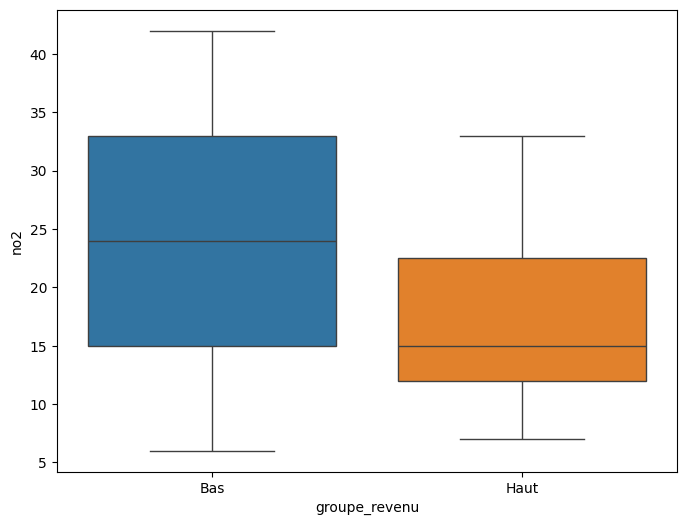

In [56]:
# On représente l'écart de moyenne pour les PM10
plt.figure(figsize=(8,6))
sns.boxplot(x="groupe_revenu", y="no2", data=communes_idf_short,
            hue = "groupe_revenu",
            legend=False)
plt.show()

On voit bien une différence mais elle est plus visible quand on prend la distribution, comme ci-dessous.

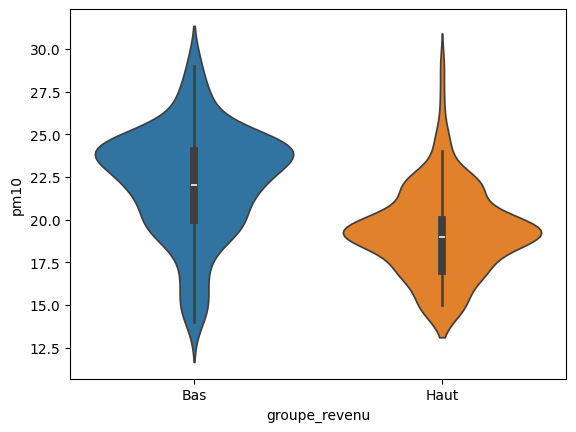

In [57]:
sns.violinplot(x="groupe_revenu", y="pm10", data=communes_idf_short,
            hue = "groupe_revenu",
            legend=False)
plt.show()

Cela est également flagrant pour l'O3, mais à l'envers (les communes riches sont plus polluées)...

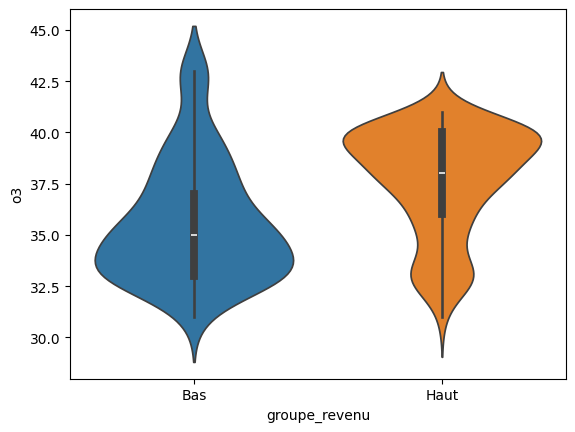

In [58]:
sns.violinplot(x="groupe_revenu", y="o3", data=communes_idf_short,
            hue = "groupe_revenu",
            legend=False)
plt.show()

... et il est difficile de se prononcer sur le NO2 ! Même si globalement les communes riches semblent condensées dans les villes peu polluées, probablement car elles sont préservées du trafic routier.

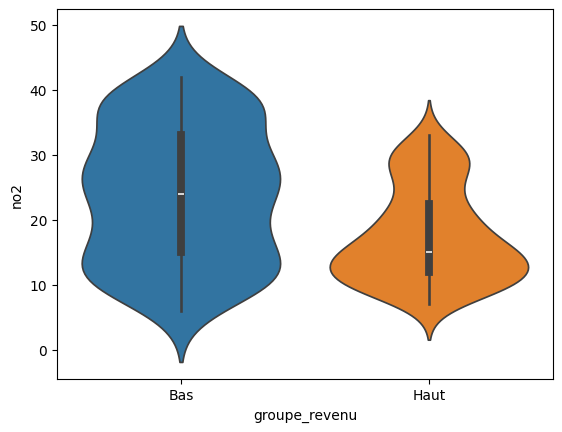

In [59]:
sns.violinplot(x="groupe_revenu", y="no2", data=communes_idf_short,
            hue = "groupe_revenu",
            legend=False)
plt.show()

*2.5. Corrélations entre pollutions*

Précisons avant de commencer ce paragraphe que, si nous étudions dans ce travail principalement la pollution atmosphérique, nous nous intéressons également aux interactions entre les types de pollution. L'objectif est ainsi de savoir i) si les territoires vulnérables socialement sont plus exposés et ii) si les pollutions sont liées entre elles (et si cela peut en soi contribuer à créer des territories vulnérables).

Dans ce dernier paragraphe de cette partie, nous regardons donc si les pollutions considérées ici sont dépendantes les unes des autres. 

In [60]:
## On crée un df réduit aux colonnes de sources de pollution pour étudier si elles sont liées entre elles

communes_idf_pollutions = communes_idf_short[
    [
     # Variables liées à la pollution industrielles tirées de Géorisques
"Polluee", "rejets_isoles", "nb_etablissements_isoles", "rejets_raccordes", "nb_etablissements_raccordes", "rejets_tot", "nb_etablissements_rejets_tot",
"nombre_etablissements_emissions", "nombre_etablissements_emissions_2_plus", "nombre_etablissements_emissions_3_plus", "nombre_etablissements_dechets",
"nombre_etablissements_dechets_2_plus", "nombre_etablissements_dechets_3_plus",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10"]
].copy()

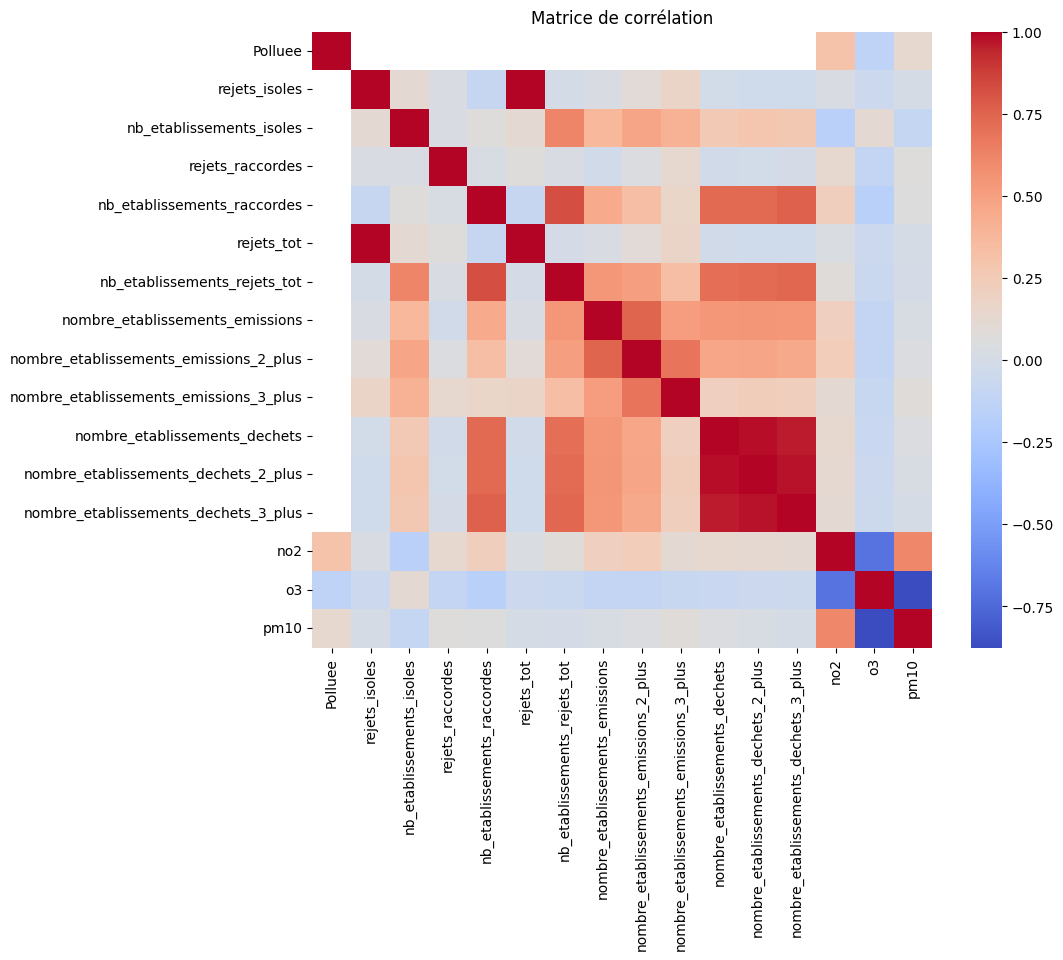

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(communes_idf_pollutions.corr(), cmap="coolwarm")  # pas de cbar=False
plt.title("Matrice de corrélation")
plt.show()

On ne voit pas grand chose, donc on crée un df encore plus réduit pour observer le rapport entre des pollutions a priori indépendantes.

In [62]:
communes_idf_pollutions2 = communes_idf_short[
    [
     # Variables liées à la pollution industrielles tirées de Géorisques
"nb_etablissements_rejets_tot", "nombre_etablissements_emissions", "nombre_etablissements_dechets",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10"]
].copy()

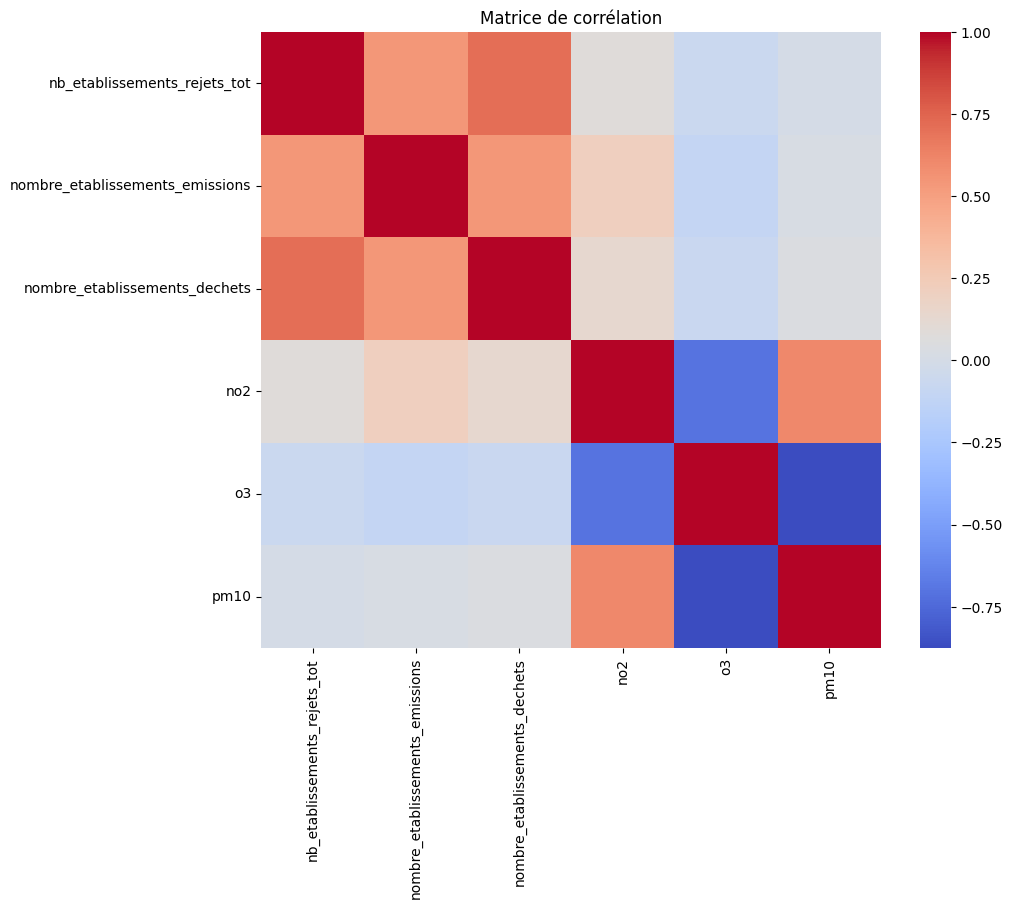

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(communes_idf_pollutions2.corr(), cmap="coolwarm")  # pas de cbar=False
plt.title("Matrice de corrélation")
plt.show()

Finalement, les pollutions de l'air sont très liées entre elles (no2 et pm10 au mêmes endroits, o3 à l'opposé), et de même des pollutions industrielles.
Le lien entre ces deux types de pollution est par contre bien moins apparent par une mesure de corrélation linéaire : seul le lien entre no2 et émissions par des établissements industriels est manifestement intéressant ici. 

Cependant, la relative indépendance linéaire des pollutions industrielle et atmosphérique peut également être un atout du point de vue de notre analyse. En effet, les zones exposées aux deux sont plus rares, et il devient d'autant plus intéressant d'étudier les caractéristiques des communes qui "cumulent" les expositions aux deux types de pollution. C'est, entre autres choses, ce que nous faisons dans la sous-partie suivante, consacrée au lien entre exposition à la pollution et caractéristiques sociodémographiques.

*2.5. Corrélations entre pollution et démographie*

In [64]:
## On crée un df réduit qui rassemble les métriques choisies pour la pollution et quelques indicateurs sociodémographiques

communes_idf_pollutions_dem = communes_idf_short[
    [
     # Variables liées à la pollution industrielles tirées de Géorisques
"nb_etablissements_rejets_tot", "nombre_etablissements_emissions", "nombre_etablissements_dechets",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10",

    # Variables démographiques
"revenu_median_2021", "population_2022", "part_agriculteurs", "part_artisans", "part_cpis", "part_pi", "part_employes", "part_ouvriers",
"croissance_demographique_2011_2022", "industries_habitant", "stations_service_habitant", "ecoles_maternelles_habitant",
"medecins_generalistes_habitant"
]
].copy()

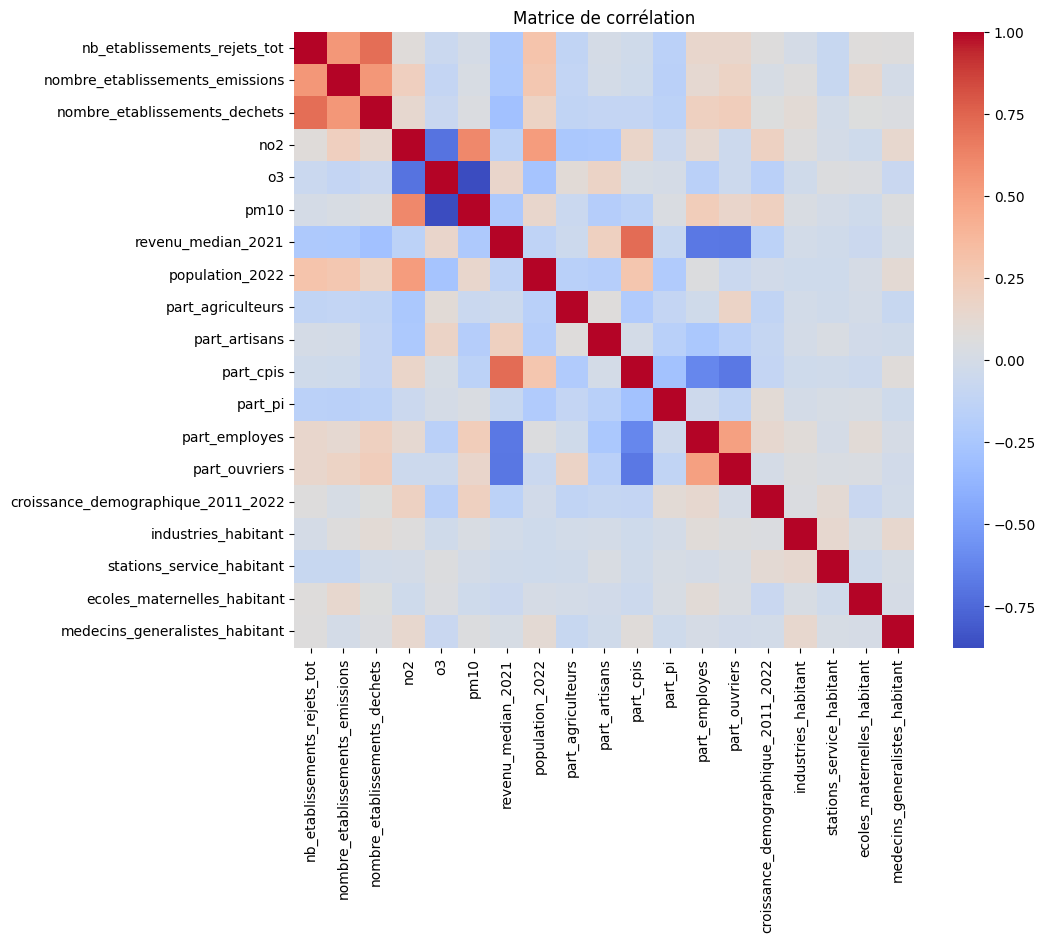

In [65]:
plt.figure(figsize=(10, 8))
sns.heatmap(communes_idf_pollutions_dem.corr(), cmap="coolwarm")  
plt.title("Matrice de corrélation")
plt.show()

On voit que rien n'est vraiment flagrant sitôt qu'on mêle les registres : pollution, démographie, géographie...

On passe donc à la modélisation pour y voir plus clair.

**Partie 3 : Modélisation**

Globalement, les analyses descriptives montrent quelques liens entre pollution et démographie, mais aucun ne paraît plus solide que celui qui est médié par la géographie : les villes les plus polluées sont manifestement proches de Paris, et davantage au nord-est de cette ville. Certes, cela traduit probablement la vulnérabilité sociale des populations qui vivent là, mais également l'histoire spécifique de ces territoires, notamment de Seine-Saint-Denis, très marqués par l'industrie. Quoi qu'il en soit, les effets spatiaux semblent l'emporter - et c'est ce qu'on va essayer de discuter dans cette partie.

Avant de commencer les analyses, on crée des nouvelles variables : distance à Paris, cos et sin de l'angle de la distance. Cela nous sera utile pour la régression car la distance au centre - qu'il n'est pas besoin de nommer... - est décisive dans la concentration des activités industrielles, du trafic routier et, ultimement, de la pollution.

In [66]:
## On crée la distance à Paris

# Coordonnées de Paris 5e
x_Paris_5 = communes_idf_short.loc[communes_idf_short["insee"] == "75105", "x"].iloc[0]
y_Paris_5 = communes_idf_short.loc[communes_idf_short["insee"] == "75105", "y"].iloc[0]

# Distance euclidienne de chaque commune au 5e
communes_idf_short["distance_a_Paris"] = np.sqrt(
    (communes_idf_short["x"] - x_Paris_5)**2 +
    (communes_idf_short["y"] - y_Paris_5)**2
)

# On prend également en compte l'angle
communes_idf_short["angle_paris"] = np.arctan2(
    communes_idf_short["y"] - y_Paris_5,
    communes_idf_short["x"] - x_Paris_5
)

# On prend le cosinus et le sinus de l'angle pour identifier le nord-est, le sud-ouest...
communes_idf_short["cos_angle"] = np.cos(communes_idf_short["angle_paris"])
communes_idf_short["sin_angle"] = np.sin(communes_idf_short["angle_paris"])

*3.1. Régression de la qualité de l'air (pm10, o3, no2) sur des variables démographiques et spatiales*

On régresse une première variable de qualité de l'air (le PM10) sur les variables dont on dispose.

In [67]:
## On régresse PM10 sur plein de variables

# Variable dépendante
y_pm10 = communes_idf_short['pm10']

# Variables explicatives
X_dem = communes_idf_short[["surf_ha", "revenu_median_2021", "densite", "Polluee", "croissance_demographique_2011_2022",
"part_agriculteurs", "part_artisans", "part_cpis", "part_pi", "part_employes", "part_ouvriers", "stations_service_habitant",
"ecoles_maternelles_habitant", "medecins_generalistes_habitant", "hotels_habitant", "industries_habitant", "creations_entreprises"
]]

# Standardiser les colonnes continues
scaler = StandardScaler()
cols_scale = ["surf_ha", "revenu_median_2021", "densite", "croissance_demographique_2011_2022",
"part_agriculteurs", "part_artisans", "part_cpis", "part_pi", "part_employes", "part_ouvriers", "industries_habitant", "stations_service_habitant",
"ecoles_maternelles_habitant", "medecins_generalistes_habitant", "hotels_habitant", "creations_entreprises"]

X_dem_scaled = pd.DataFrame(scaler.fit_transform(X_dem[cols_scale]),

                        columns=cols_scale,

                        index=X_dem.index)

# On ajoute la variable binaire sans standardisation
X_dem_scaled['Polluee'] = X_dem['Polluee'].astype(int)

# On ajoute l'intercept
X_dem_const = sm.add_constant(X_dem_scaled)

# Construction et ajustement du modèle
model_pm10_dem_std = sm.OLS(y_pm10, X_dem_const).fit()

# Résumé complet
print(model_pm10_dem_std.summary())

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     14.36
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           3.53e-38
Time:                        14:55:58   Log-Likelihood:                -3345.7
No. Observations:                1270   AIC:                             6727.
Df Residuals:                    1252   BIC:                             6820.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

Ce n'est pas très satisfaisant. On va essayer de supprimer des variables, d'abord en contrôlant les VIFs puis à la main.

In [68]:
# On affiche les VIF (VIF > 5 : variable très corrélées aux autres variables du modèle)

vif_data = pd.DataFrame()
vif_data["feature"] = X_dem_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_dem_scaled.values, i) for i in range(X_dem_scaled.shape[1])]
print(vif_data)

                               feature       VIF
0                              surf_ha  1.120347
1                   revenu_median_2021  3.864909
2                              densite  2.359046
3   croissance_demographique_2011_2022  1.124202
4                    part_agriculteurs  1.222754
5                        part_artisans  1.458561
6                            part_cpis  5.971050
7                              part_pi  1.928715
8                        part_employes  2.669617
9                        part_ouvriers  3.145146
10                 industries_habitant  1.117447
11           stations_service_habitant  1.038564
12         ecoles_maternelles_habitant  1.020164
13      medecins_generalistes_habitant  1.050224
14                     hotels_habitant  1.103821
15               creations_entreprises  1.799724
16                             Polluee  1.226292


In [69]:
## On écrit une fonction pour supprimer, de façon itérative, les variables avec un fort VIF

def reduce_vif(X, threshold=5):
    X = X.copy()
    
    while True:
        vif = pd.DataFrame({
            "feature": X.columns,
            "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })
        
        max_vif = vif["VIF"].max()
        
        if max_vif <= threshold:
            break
        
        feature_to_drop = vif.loc[vif["VIF"].idxmax(), "feature"]
        print(f"Suppression de {feature_to_drop} (VIF = {max_vif:.2f})")
        
        X = X.drop(columns=[feature_to_drop])
    
    return X

In [70]:
# On applique la fonction : on supprime une par une les variables à fort VIF (ie très corrélées entre elles)
X_for_vif = X_dem_scaled.drop(columns=['Polluee'])
X_dem_reduced = reduce_vif(X_for_vif, threshold=5)
X_dem_reduced['Polluee'] = X_dem_scaled['Polluee']

Suppression de part_cpis (VIF = 5.90)


In [71]:
## On refait la régression avec moins de régresseurs

# On ajoute l'intercept
X_dem_reduced_const = sm.add_constant(X_dem_reduced)

# Construction et ajustement du modèle
model_pm10_dem_std_reduced = sm.OLS(y_pm10, X_dem_reduced_const).fit()

# Résumé complet
print(model_pm10_dem_std_reduced.summary())      

### REMARQUE : on a diminué les AIC et BIC mais le R^2 est toujours faible. On va faire mieux avec l'O3 et surtout le NO2.

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     14.88
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           1.06e-37
Time:                        14:55:58   Log-Likelihood:                -3348.4
No. Observations:                1270   AIC:                             6731.
Df Residuals:                    1253   BIC:                             6818.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

On passe à l'O3 puis, surtout, au NO2. Cette dernière variable est de loin la mieux prédite, donc on va perfectionner notre régression sur celle-ci.

In [72]:
#### Régression du o3 sur les variables "non spatiales"

# Variable dépendante
y_o3 = communes_idf_short['o3']

# Construction et ajustement du modèle
model_o3_dem_std = sm.OLS(y_o3, X_dem_const).fit()

# Résumé complet
print(model_o3_dem_std.summary())

### REMARQUE : le R^2 est légèrement meilleur (0.164) mais pareil pour les variables (à part densité, revenu médian et surface un peu)

                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     20.25
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           6.90e-55
Time:                        14:55:58   Log-Likelihood:                -3020.9
No. Observations:                1270   AIC:                             6078.
Df Residuals:                    1252   BIC:                             6170.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [73]:
## Pareil sur le modèle réduit

# Construction et ajustement du modèle
model_o3_dem_std_reduced = sm.OLS(y_o3, X_dem_reduced_const).fit()

# Résumé complet
print(model_o3_dem_std_reduced.summary())      

                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     21.39
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           3.30e-55
Time:                        14:55:58   Log-Likelihood:                -3021.8
No. Observations:                1270   AIC:                             6078.
Df Residuals:                    1253   BIC:                             6165.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

Comme prévu, on passe au NO2, et on réduit peu à peu les variables utilisées, afin de diminuer le AIC et le BIC.

In [74]:
#### Régression du no2 sur les variables "non spatiales"

# Variable dépendante
y_no2 = communes_idf_short['no2']

# Construction et ajustement du modèle
model_no2_dem_std = sm.OLS(y_no2, X_dem_const).fit()

# Résumé complet
print(model_no2_dem_std.summary())

### REMARQUE : le R^2 est nettement meilleur (0.454) et quelques variables ont un rôle notable (densité, polluee, popuation, revenu médian)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     61.20
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          7.03e-151
Time:                        14:55:58   Log-Likelihood:                -3968.4
No. Observations:                1270   AIC:                             7973.
Df Residuals:                    1252   BIC:                             8065.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [75]:
#### Pareil sur le modèle réduit

# Construction et ajustement du modèle
model_no2_dem_std = sm.OLS(y_no2, X_dem_reduced_const).fit()

# Résumé complet
print(model_no2_dem_std.summary())

### REMARQUE : le R^2 baisse à peine.

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     65.01
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          1.11e-151
Time:                        14:55:58   Log-Likelihood:                -3968.6
No. Observations:                1270   AIC:                             7971.
Df Residuals:                    1253   BIC:                             8059.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

On supprime beaucoup de variables d'un coup, pour éviter d'afficher dix tableaux presque identiques...

In [76]:
# On supprime plein de variables jugées non pertinentes (après analyse)
X_dem_reduced_const2 = X_dem_reduced_const.drop(columns=['ecoles_maternelles_habitant','part_pi', 'part_employes',
'stations_service_habitant', 'creations_entreprises', 'medecins_generalistes_habitant'])  
model_no2_dem_std2 = sm.OLS(y_no2, X_dem_reduced_const2).fit()
print(model_no2_dem_std2.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     101.0
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          2.65e-153
Time:                        14:55:58   Log-Likelihood:                -3978.5
No. Observations:                1270   AIC:                             7979.
Df Residuals:                    1259   BIC:                             8036.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

A ce stade, on obtient un R^2 ajusté de 0.44, avec des variables significative très intéressantes : par exemple, le fait d'être "polluée" (ie, d'avoir au moins une industrie polluante au sens où 14% des communes environ en ont une) augmente de près de deux écarts-type la concentration en NO2 ; cela monte à plus de trois écarts-ype pour une unité supplémentaire de densité.

De façon plus surprenante, le lien entre revenu médian et NO2 est significatif, puisque les villes plus riches sont moins polluées. De même du lien entre croissance démographique : les villes en croissance sont a priori plus polluées, peut-être simplement car ce sont les plus grandes villes, attractives et denses en activité industrielle comme en trafic routier.

On ajoute maintenant les coordonnées géographiques, dont on peut s'attendre au regard des cartes réalisées plus haut à ce qu'elles soient déterminantes.

In [77]:
### On ajoute à la régression les coordonnées géographiques pour voir si cela annule tout le reste

# On crée le df démographique et spatial
X_dem_spatial = X_dem_reduced_const2
X_dem_spatial[["x", "y"]] = communes_idf_short[["x", "y"]]

# on standardise
scaler = StandardScaler()
X_dem_spatial[["x", "y"]] = scaler.fit_transform(X_dem_spatial[["x", "y"]])

# On construit le modèle
model_no2_dem_spatial = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial.summary())

### REMARQUE : au total, x et y augmentent nettement le R^2 mais n'écrasent pas le reste.

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     134.2
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          3.84e-215
Time:                        14:55:58   Log-Likelihood:                -3828.8
No. Observations:                1270   AIC:                             7684.
Df Residuals:                    1257   BIC:                             7750.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [78]:
### On ajoute l'effet croisé surface*densité

# Nouvelle variable
X_dem_spatial['densite_surf'] = X_dem_spatial['densite'] * X_dem_spatial['surf_ha']

# On construit le modèle
model_no2_dem_spatial2 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial2.summary())

### REMARQUE : l'effet croisé semble fort et augmente un peu le R^2 (grandes villes et denses = les plus polluées)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     126.4
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          2.43e-217
Time:                        14:55:58   Log-Likelihood:                -3821.1
No. Observations:                1270   AIC:                             7670.
Df Residuals:                    1256   BIC:                             7742.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

On a un R^2 meilleur mais qui laisse encore de la place aux variables démographiques (densité) et sociales (part d'ouvriers). Par ailleurs, certaines variables, telles que cette dernière, deviennent significatives alors qu'elles ne l'étaient pas avant : dans le cas de la part d'ouvriers, cela provient sans doute de ce que, à latitude et longitude égales, la composante plus ou moins ouvrière de la commune témoigne de la densité en industries de la zone et donc de la pollution potentielle.

On visualise l'effet croisé densité - surface

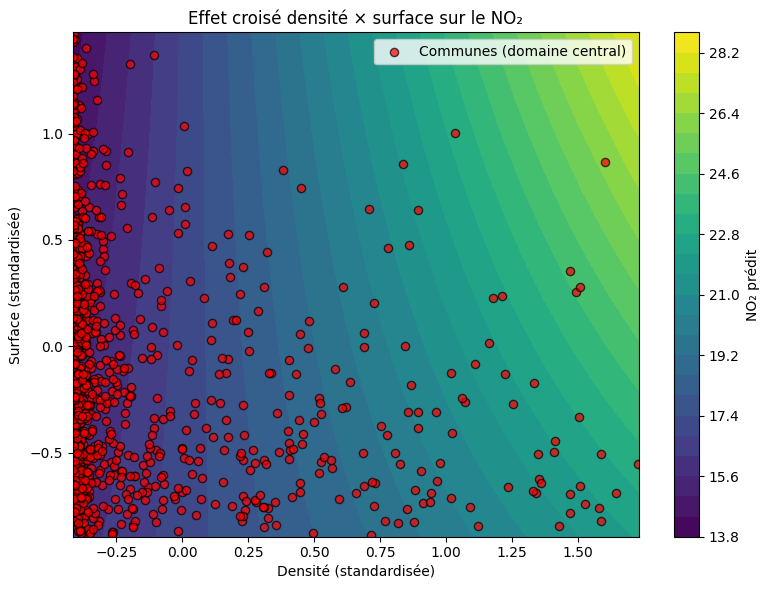

In [79]:
# On crée des valeurs avec les minima et maxima pour les deux variables (pour le graphique)
x_min, x_max = X_dem_spatial["densite"].quantile(0.05), X_dem_spatial["densite"].quantile(0.95)
y_min, y_max = X_dem_spatial["surf_ha"].quantile(0.05), X_dem_spatial["surf_ha"].quantile(0.95)

# On crée des valeurs dans ce carré
x_vals = np.linspace(x_min, x_max, 60)
y_vals = np.linspace(y_min, y_max, 60)
X, Y = np.meshgrid(x_vals, y_vals)

# On récupère les coefficients du modèle pour afficher les valeurs prédites
coef = model_no2_dem_spatial2.params

# On enregistre les coefficients d'intérêt dans Z
Z = (
    coef["const"]
    + coef["densite"] * X
    + coef["surf_ha"] * Y
    + coef["densite_surf"] * X * Y
)

# On crée un masque avec la condition "x et y sont dans le carré (ie, entre le minimum et le maximum de chaque variable)"
mask = (
    X_dem_spatial["densite"].between(x_min, x_max)
    & X_dem_spatial["surf_ha"].between(y_min, y_max)
)

# On crée des objets avec les variables restreintes à la condition souhaitée
x_plot = X_dem_spatial["densite"][mask]
y_plot = X_dem_spatial["surf_ha"][mask]

# On affiche la heatmap
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, Z, levels=25, cmap="viridis")
plt.colorbar(cp, label="NO₂ prédit")
plt.scatter(
    x_plot, y_plot,
    c="red",
    edgecolor="black",
    s=35,
    alpha=0.7,
    label="Communes (domaine central)"
)
plt.xlabel("Densité (standardisée)")
plt.ylabel("Surface (standardisée)")
plt.title("Effet croisé densité × surface sur le NO₂")
plt.legend()
plt.tight_layout()
plt.show()


Globalement, on voit que le modèle prédit une pollution plus forte quand la densité augmente, avec un effet léger de la surface, qui est cependant difficilement interprétable car les villes denses sont concentrées plutôt en bas de la distribution des surfaces.

On continue dans la régression.

In [80]:
### On ajoute l'effet croisé x*y

# Nouvelle variable
X_dem_spatial['x_y'] = X_dem_spatial['x'] * X_dem_spatial['y']

# On construit le modèle
model_no2_dem_spatial3 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial3.summary())

### REMARQUE : l'effet croisé est significatif et augmente encore un peu le R^2 : être au nord-est est plus fort qu'être au nord et à l'est

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     127.9
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          9.73e-230
Time:                        14:55:58   Log-Likelihood:                -3789.5
No. Observations:                1270   AIC:                             7609.
Df Residuals:                    1255   BIC:                             7686.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

On a ajouté l'effet croisé des coordonnées x et y, et cela augmente encore un peu le R^2.

On change maintenant de perspective ; on prend la distance à Paris et l'angle de la distance plutôt que les coordonnées "brutes".

In [81]:
X_dem_spatial["distance_a_Paris"] = communes_idf_short["distance_a_Paris"]
X_dem_spatial["cos_angle"] = communes_idf_short["cos_angle"]
X_dem_spatial["sin_angle"] = communes_idf_short["sin_angle"]

model_no2_dem_spatial4 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial4.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     391.5
Date:                Sat, 27 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:55:58   Log-Likelihood:                -3182.0
No. Observations:                1270   AIC:                             6400.
Df Residuals:                    1252   BIC:                             6493.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

On obtient un R^2 ajusté de 0.84, ce qui confirme la domination de la dimension spatiale sur les autres. En tout cas, les autres dimensions, notamment spatiales, ne prennent sens que projetées dans l'espace géographique - et, de fait, beaucoup de variables sociales deviennent non significatives une fois qu'on contrôle par l'espace. 

A noter cependant que le revenu médian continue d'être très significatif, même si l'effet est faible.

On ajoute la distance au carré ou encore son logarithme mais, comme attendu, l'effet linéaire est déjà très fort et continue de l'emporter. Cela dit, le logarithme de la distance est important, ce qui suggère que, plus on s'éloigne de Paris, plus l'effet est faible : autrement dit, l'effet de la distance à Paris est "net" et, passée une certaine distance, s'éloigner davantage ne joue plus beaucoup.

In [82]:
X_dem_spatial["distance_2"] = X_dem_spatial["distance_a_Paris"]**2
X_dem_spatial["distance_ln"] = np.log1p(
    X_dem_spatial["distance_a_Paris"].clip(lower=0)
)

scaler = StandardScaler()
X_dem_spatial[["distance_a_Paris", "distance_2", "distance_ln", "cos_angle", "sin_angle"]] = scaler.fit_transform(
    X_dem_spatial[["distance_a_Paris", "distance_2", "distance_ln", "cos_angle", "sin_angle"]])

model_no2_dem_spatial5 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial5.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     576.4
Date:                Sat, 27 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:55:58   Log-Likelihood:                -2905.6
No. Observations:                1270   AIC:                             5851.
Df Residuals:                    1250   BIC:                             5954.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

On représente l'effet de la distance et de la direction, et on retrouve quelque chose proche de la carte affichée au début...

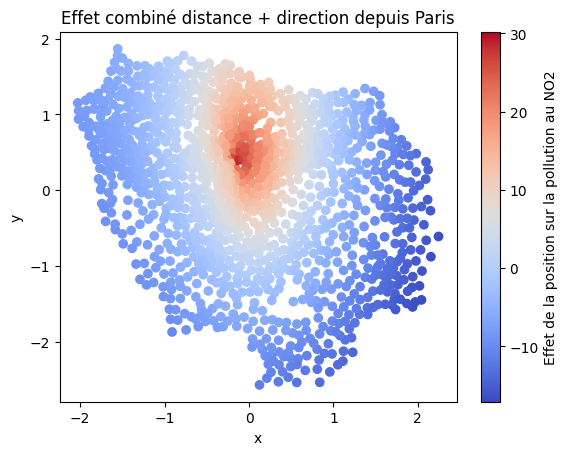

In [83]:
# On récupère les coefficients de la régression
coefs_spatial_5 = model_no2_dem_spatial5.params

# On crée l'effet de la géographie (en prenant en compte x, y, distance, log(distance), cos(angle) et sin(angle))
effet = (
    coefs_spatial_5["distance_a_Paris"] * X_dem_spatial["distance_a_Paris"]
    + coefs_spatial_5["cos_angle"] * X_dem_spatial["cos_angle"]
    + coefs_spatial_5["sin_angle"] * X_dem_spatial["sin_angle"]
    + coefs_spatial_5["distance_ln"] * X_dem_spatial["distance_ln"]
    + coefs_spatial_5["x"] * X_dem_spatial["x"]
    + coefs_spatial_5["y"] * X_dem_spatial["y"]
)

# On visualise le tout
plt.scatter(
    X_dem_spatial["x"],
    X_dem_spatial["y"],
    c=effet,
    cmap="coolwarm"
)
plt.colorbar(label="Effet de la position sur la pollution au NO2")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Effet combiné distance + direction depuis Paris")
plt.show()

*3.2. Analyse de l'autocorrélation spatiale dans notre régression OLS finale*

On va désormais analyser les résidus du modèle de la régression OLS. Cela nous permettra de détecter d'éventuels effets spatiaux non pris en compte par le modèle. En effet, les résidus correspondent à la différence entre les concentrations de NO2 observées et les valeurs prédites par le modèle à partir des variables explicatives. Ils capturent donc la part de la pollution non expliquée par les variables socio-démographiques que nous avons sélectionnées dans la régression.

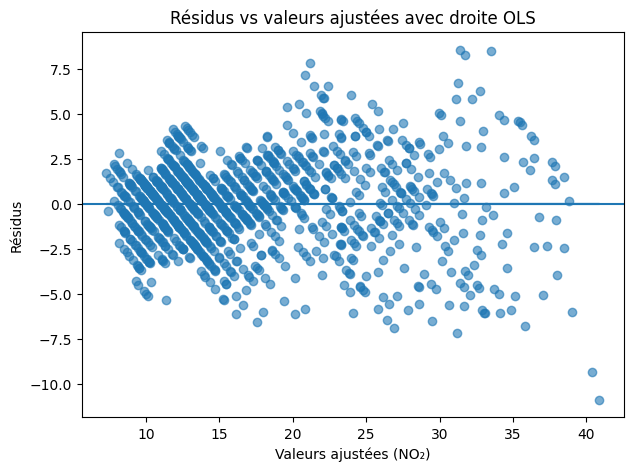

In [84]:
# On récupère les résidus de la dernière régression ainsi que les valeurs prédites
residuals = model_no2_dem_spatial5.resid
fitted = model_no2_dem_spatial5.fittedvalues

# On ajoute une constante aux valeurs prédites pour les régresser, ensuite, sur les résidus
fitted_cst = sm.add_constant(fitted)
fitted_model = sm.OLS(residuals, fitted_cst).fit()
resid_pred = fitted_model.fittedvalues

# Graphique qui affiche les résidus du modèle selon les valeurs prédites
plt.figure(figsize=(7,5))
plt.scatter(fitted, residuals, alpha=0.6)
plt.plot(fitted, resid_pred)
plt.axhline(0)
plt.xlabel("Valeurs ajustées (NO₂)")
plt.ylabel("Résidus")
plt.title("Résidus vs valeurs ajustées avec droite OLS")
plt.show()

Le graphique représente les résidus du modèle en fonction des valeurs ajustées de NO2. L'axe horizontal représente les valeurs de NO2 prédites par le modèle, et l'axe vertical représente les résidus. Chaque point correspond à une commune. Par construction, la régression OLS des résidus sur les valeurs ajustées conduit à une droite horizontale.
En revanche, la dispersion croissante des résidus avec le NO2 prédit suggère que les erreurs sont plus grandes dans les zones fortement polluées, marque d'une hétéroscédasticité marquée. Donc les résidus ne sont pas distribués au hasard. Cette hétérogénéité reflète probablement des effets locaux ou spatiaux non capturés par la spécification linéaire du modèle.

Pour vérifier cela, on fait un test d'hétéroscédasticité.

In [85]:
test_heteroscedasticite = sms.het_breuschpagan(
    model_no2_dem_spatial5.resid,
    model_no2_dem_spatial5.model.exog
)
print("LM stat     :", test_heteroscedasticite[0])
print("p-value LM  :", test_heteroscedasticite[1])

LM stat     : 267.7301149539541
p-value LM  : 7.788654931999448e-46


On a fait un test de Breusch-Pagan, avec comme hypothèse nulle que la variance des résidus est constante (homoscédasticité) et comme hypothèse alternative que cette variance dépend des variables explicatives (hétéroscédasticité).
On obtient que la statistique LM est très élevée, suggérant une déviation par rapport à l'hypothèse d'homoscédasticité. La p-value est très faible (inférieure à 1% très largement) donc on rejette l'hypothèse nulle.
Cela nous indique que la variance des résidus dépend des variables explicatives. Donc la variabilité des erreurs augmente avec certaines caractéristiques territoriales, comme dans les zones plus exposées à la pollution.

On va ainsi chercher à afficher l'autocorrélation spatiale locale et à visualiser les clusters spatiaux des résidus

In [86]:
# Ajout des résidus à la base communes_idf_short
communes_idf_short = communes_idf_short.copy()
communes_idf_short["residuals"] = model_no2_dem_spatial5.resid.values

On va standardiser les résidus afin de faciliter leur interprétation et rendre les statistiques d'autocorrélation spatiale comparables entre unités spatiales.

In [87]:
# Standardisation 
communes_idf_short["residuals_std"] = (
    (communes_idf_short["residuals"] - communes_idf_short["residuals"].mean())
    / communes_idf_short["residuals"].std()
)

On construit une structure de voisinage reliant les communes entre elles. On prend un modèle de Queen contiguity qui considère deux communes comme voisines si elles partagent au moins un point de frontière. Cela nous permet de capturer des interactions spatiales locales indépendamment de la taille ou forme des communes.

In [88]:
# Matrice de voisinage Queen
w = Queen.from_dataframe(communes_idf_short, ids=communes_idf_short.index.tolist())

/opt/python/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


On normalise la matrice des poids spatiaux par ligne afin de comparer l'influence des voisins d'une communes entre les territoires.

In [89]:
w.transform = "R"  # normalisation de chaque ligne

Ensuite, on teste l'existence d'une autocorrélation spatiale globale des résidus à l'aide de l'indice de Moran. Cela nous permettra de voir si les erreurs de prédiction du modèle sont spatialement structurées, ou si au contraire, elles sont distribuées aléatoirement dans l'espace.

L'hypothèse nulle du test correspond à une absence d'autocorrélation spatiale, cela signifierait que les résidus sont indépendants de la localisation géographique des communes.

Si l'indice de Moran et positif et significatif, cela indique que les communes qui présentes des résidus élevés ou faibles sont géographiquement proches, donc que notre modèle OLS ne capture pas certains effets spatiaux.

In [90]:
moran_res = Moran(communes_idf_short["residuals_std"], w)

print("I de Moran global :", round(moran_res.I, 3))
print("p-value          :", moran_res.p_sim)

I de Moran global : 0.833
p-value          : 0.001


On voit que le I de Moran est supérieur à 0, ce que indique une autocorrélation spatiale positive. La très faible p-value est le signe d'une structure spatiale significative des résidus. Cela justifie un modèle d'analyse spatiale.

On va maintenant construire les LISA des résidus pour renseigner la localisation précise de ces phénomènes spatiaux. Les LISA sont des indicateurs locaux d'autocorrélation qui comparent pour chaque commune son résidu aux résidus des communes voisines. 


En effet, un résidu positif indique que le NO2 observé est plus élevé que ce que le modèle prédit, tandis qu'un résidu négatif indique que le NO2 observé est plus faible que ce que le modèle prédit. Les LISA permettent ainsi d'identifier pour chaque commune si ses résidus sont similaires à ceux de ses voisines immédiates et de voir si la commune fait partie d'un groupe spatial où le modèle se trompe de la même façon.

 Cela mettra en évidence des clusters spatiaux locaux, c'est à dire des groupes de communes qui partagent des erreurs de prédiction similaires.

In [91]:
lisa = Moran_Local(communes_idf_short["residuals_std"], w)

On catégorise les communes en High-High, Low-Low, High-Low, Low-High, ce qui correspond respectivement aux zones de résidus élevés ou faibles, entourées de communes similaires ou dissemblables.

In [92]:
# Significativité
communes_idf_short["lisa_sig"] = lisa.p_sim < 0.05

# Quadrants LISA
communes_idf_short["lisa_cluster"] = lisa.q

# Catégorisatin des communes
lisa_labels = {
    1: "High-High",
    2: "Low-High",
    3: "Low-Low",
    4: "High-Low"
}

communes_idf_short["lisa_label"] = communes_idf_short["lisa_cluster"].map(lisa_labels)
communes_idf_short.loc[~communes_idf_short["lisa_sig"], "lisa_label"] = "Non significatif"


On corrige du risque global. Pour cela on réalise un test statistique pour chaque commune. Comme la réalisation de tests augmente mécaniquement le risque de détecter à tort une autocorrélation spatiale locale, on ajuste les p-values à l'aide de la méthode de Benjamini-Hochberg, qui contrôle le taux de fausses découvertes. On identifiera ainsi in fine les clusters spatiaux réellement significatifs.

In [93]:
# On crée les variables
reject, pvals_fdr, _, _ = multipletests(
    lisa.p_sim,
    method="fdr_bh"
)

# On ajoute les colonnes au tableau initial
communes_idf_short["pval_fdr"] = pvals_fdr
communes_idf_short["lisa_sig_fdr"] = reject

# On ajoute une colonne pour indiquer si le test n'est pas significatif
communes_idf_short.loc[~communes_idf_short["lisa_sig_fdr"], "lisa_label"] = "Non significatif"

On affiche la carte des LISA (résidus du NO2). Cela nous permet de visualiser à la fois la distribution spatiale des résidus du modèle et les clusters locaux d'autocorrélation spatiale identifiés par les LISA.

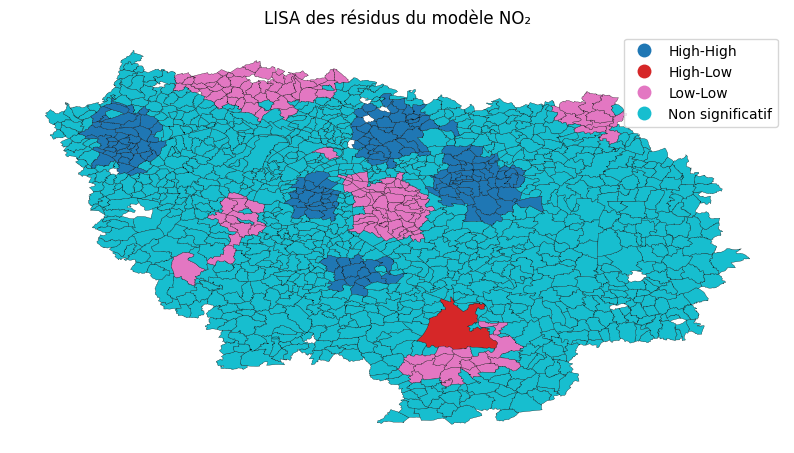

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

communes_idf_short.plot(
    column="lisa_label",
    categorical=True,
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.2
)

ax.set_title("LISA des résidus du modèle NO₂")
ax.axis("off")

plt.show()

La représentation cartographique met en évidence des zones où le modèle OLS sous-estime ou surestime les concentrations de NO2, ainsi que les poches spatiales où les erreurs sont spatialement corrélées. 

Les communes en high-high indiquent que le résidu est élevé dans la commune et que les résidus sont également élevés dans les communes voisines. Donc que le modèle sous-estime systématiquement le NO2 dans cette zone et le sous estime également dans les communes voisines. Donc il existe un facteur local commun non inclus dans le modèle (trafic routier ? activité industrielle pas identifiée par nos données ? vents typiques ?)

A l'inverse, les zones low-low indique que le résidu est faible dans la commune et dans les communes voisines. Donc que dans ces zones, le modèle surestime systématiquement le NO2. Cette surestimation est spatialement concentrée.

Les communes high-low indiquent que le résidu est élevé dans la commune/faible dans les communes voisines. Donc que la commune est anormalement plus polluée que ce que prédit le modèle, par rapport aux communes aux alentours, signe d'une spécificité locale. A l'inverse, dans les communes low-high, la commune est moins polluée que prévu, alors qu'elle est entourée de communes où le modèle sous-estime le NO2, signe d'un effet local positif

Dans les communes non significatives, aucune structure spatiale locale n'est détectée.

Ainsi, la visualisation des LISA sur la carte d'Ile-de-France met en évidence des clusters spatiaux significatifs de communes présentant des erreurs de prédiction similaires. Cela confirme la présence d’effets spatiaux locaux non pris en compte par la spécification linéaire initiale et justifie le recours à des modèles économétriques spatiaux plus élaborés qui intègrent les interactions spatiales.

*3.3. Régression du revenu (variable sociale) sur les variables environnementales*

On cherche maintenant à expliquer inversement le revenu par l'exposition à la pollution, conditionnellement à la géographie.

On construit ainsi une régression qui prend en compte la pollution et la géographie (afin de saisir l'effet propre de la pollution) et une dernière qui ne prend en compte que la pollution, pour voir si le modèle reste explicatif. On s'aperçoit, dans les deux cas, que la pollution joue un rôle mineur dans l'explication de la variation du revenu, mais qu'elle est significative.

In [95]:
# Variable dépendante
y_revenu = communes_idf_short["revenu_median_2021"]

# Variables explicatives liées à la pollution
X_pollution = communes_idf_short[
    ['rejets_isoles', 'nb_etablissements_isoles', 'rejets_raccordes', 'nb_etablissements_raccordes', 'rejets_tot',
       'nb_etablissements_rejets_tot', 'nombre_etablissements_emissions', 'nombre_etablissements_emissions_2_plus',
       'nombre_etablissements_emissions_3_plus', 'nombre_etablissements_dechets', 'nombre_etablissements_dechets_2_plus',
       'nombre_etablissements_dechets_3_plus', 'no2', 'o3', 'pm10', "densite", "surf_ha", "distance_a_Paris", "cos_angle", "sin_angle"
    ]
].copy()

# Effet croisé densité * surface
X_pollution["densite_surf"] = (
    X_pollution["densite"] * X_pollution["surf_ha"]
)

Certaines variables explicatives comme la présence d'industries contiennent des valeurs manquantes  pour certaines communes. On procède donc à un nettoyage des variables explicatives et de la variable dépendante en supprimant les observations concernées avant l’estimation du modèle pour pouvoir appliquer la méthode des moindre carrés ordinaires.

In [96]:
# pour les communes qui n'ont pas d'établissements rejetant des déchets ou rejets, on met des 0 dans les colonnes correspondantes
X_pollution = X_pollution.fillna(0)
X_pollution_model = pd.concat([y_revenu, X_pollution], axis=1)

# Suppression des inf et des NA restants
X_pollution_model = X_pollution_model.replace([np.inf, -np.inf], np.nan).dropna()

# Séparation finale
y_revenu_clean = X_pollution_model["revenu_median_2021"]
X_pollution_clean = X_pollution_model.drop(columns="revenu_median_2021")

# On garde toutes nos lignes (même si beaucoup de variables sont pleines de zéros)
print(f"Nombre d'observations conservées : {len(y_revenu_clean)}")

Nombre d'observations conservées : 1270


In [97]:
# Standardisation des colonnes
cols_scale =  ['nb_etablissements_rejets_tot', 'nombre_etablissements_emissions', 'nombre_etablissements_dechets', 'no2', 'o3', 'pm10', "densite",
"surf_ha", "distance_a_Paris", "cos_angle", "sin_angle"]

scaler = StandardScaler()

X_pollution_scaled = pd.DataFrame(
    scaler.fit_transform(X_pollution_clean[cols_scale]),
    columns=cols_scale,
    index=X_pollution_clean.index
)

# On rajoute l'intercept
X_pollution_scaled_const = sm.add_constant(X_pollution_scaled)

# Construction et estimation du modèle
model_revenu_pollution = sm.OLS(
    y_revenu_clean,
    X_pollution_scaled_const
).fit()

print(model_revenu_pollution.summary())

                            OLS Regression Results                            
Dep. Variable:     revenu_median_2021   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     68.88
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          1.56e-120
Time:                        14:56:01   Log-Likelihood:                -12145.
No. Observations:                1270   AIC:                         2.431e+04
Df Residuals:                    1258   BIC:                         2.438e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [98]:
# On construit un modèle robuste à l'hétéroscédasticité
model_revenu_pollution_robust = model_revenu_pollution.get_robustcov_results(
    cov_type="HC1"
)
print(model_revenu_pollution_robust.summary())

                            OLS Regression Results                            
Dep. Variable:     revenu_median_2021   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     59.41
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          3.23e-106
Time:                        14:56:01   Log-Likelihood:                -12145.
No. Observations:                1270   AIC:                         2.431e+04
Df Residuals:                    1258   BIC:                         2.438e+04
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Le R2 ajusté de la régression ci-dessus est de 0,370, ce qui signifie que modèle explique 38% de la variance du revenu médian communal, il est donc pertinent. La p-value est de 7,06e-109 donc le modèle est très significatif, on rejette l'hypothèse que tous les coefficients sont nuls. 

Si l'on prend les coefficients individuellement, on remarque, par exemple, que le NO2 a un effet négatif fort et significatif, avec un coefficient associé de -2 295. Cela signifie qu'une augmentation d’un écart-type de NO₂ est associée à une baisse moyenne d'environ 2 300 euros du revenu médian. Cela est cohérent avec la concentration de ce polluant dans des zones urbaines denses et territoires moins favorisés. De même, le O3, avec un coefficient de - 1080 et une p value inférieure à 0,001, a un effet négatif significatif, bien que plus modéré. L'ozone est souvent plus présent en périphérie et reste associé à des revenus plus faibles. En revanche, le coefficient associé au PM10 est non significatif (p-value de 0,378).

L'effet de la pollution industrielle est moins flagrant, mais la présence d'un établissement de déchets supplémentaire est associée à une baisse significative du revenu médian, avec un coefficient de -1 104 et une p-value inférieure à 0,001. Cela est cohérent avec la localisation de ces établissements dans des zones moins attractives, mais on ne peut rien des établissement à émissions ou à rejets toxiques.

Au total, cette régression montre que la pollution atmosphérique est socialement différenciée, avec des concentration de NO2 et O3 dans des zones avec des revenus plus faibles. De plus, les activités polluantes renforcent les inégalités territoriales, par la présence d'établissements de déchets dans des espaces vulnérables socialement.

Finalement, comme dans la régression précédente, la distance à Paris joue un rôle important dans le modèle avec un coefficient de -2 484 et une p-value inférieure à 0,001. Donc plus la commune est éloignée de Paris, plus son revenu médian est faible. Cela confirme le rôle structurant de la capitale. L'orientation géographique par rapport à Paris est de même significative (avec un coefficient de l'angle cosinus de -1 120).

On essaie donc de voir si, en enlevant les variables géographiques, on continue d'avoir un modèle explicatif.

In [99]:
X_pollution_scaled_const2 = X_pollution_scaled_const.drop(columns={"densite", "surf_ha", "distance_a_Paris", "cos_angle", "sin_angle"})
model_revenu_pollution2 = sm.OLS(
    y_revenu_clean,
    X_pollution_scaled_const2
).fit()
print(model_revenu_pollution2.summary())

                            OLS Regression Results                            
Dep. Variable:     revenu_median_2021   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     33.91
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           4.23e-38
Time:                        14:56:01   Log-Likelihood:                -12349.
No. Observations:                1270   AIC:                         2.471e+04
Df Residuals:                    1263   BIC:                         2.475e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Au total, trois de nos variables de pollution ont un rôle significatif et clair - le revenu médian diminue quand elles augmentent. Cependant, la variance du revenu expliquée de la sorte reste faible, et bien inférieure, en particulier, à celle expliquée par le modèle spatial : on passe, pour le R^2 ajusté, de 0,370 à 0,135.

L'hypothèse la plus probable, dans ces conditions, est que la concentration des pollutions dans les espaces les plus pauvres est i) partiellement fausse (car les communes les plus polluées sont certes plus pauvres mais également industrielles, denses et proches de Paris) et ii) très liée à des logiques spatiales.

Par exemple, il est possible de supposer que les populations les plus pauvres (en particulier les ouvriers) ont été assignés historiquement à des zones polluées (car l'industrie était présente ici, ou car la bourgeoisie de l'époque préférait les zones moins exposées au vent...), et que la corrélation entre pollution et pauvreté en résulte. Mais un éventuel lien causal ne pourrait être vérifié ou infirmé que par l'analyse historique car, comme notre analyse économétrique le suggère, l'essentiel de la corrélation est aujourd'hui projetée dans un lien linéaire beaucoup plus fort entre pollution et position dans l'espace.

En particulier, comme les zones denses, industrielles et voisines de Paris sont justement les zones populaires de la région (pour des raisons historiques), il est difficile de saisir l'effet du revenu sur la pollution une fois qu'on contrôle par ces variables...

**Conclusion**

Notre projet consistait à analyser les liens potentiels entre vulnérabilité sociale et environnementale. Au fil de notre travail, nous nous sommes concentrés sur les variables environnementales liées à la pollution, à travers différents indicateurs : la présence d'industries polluantes, la concentration des rejets polluants, et les concentrations atmosphériques de différents polluants tels que le NO2, PM10, et O3. Nous nous sommes également centrés sur la région Ile-de-France afin de mieux cerner les disparités locales.

À l’issue de ce projet, il apparaît que, si certaines formes de pollution atmosphériques sont effectivement corrélées aux caractéristiques sociales des territoires, le facteur explicatif le plus structurant demeure la dimension géographique. En effet, la distance au centre métropolitain parisien et l’orientation spatiale des communes jouent un rôle déterminant dans la structuration des inégalités de revenus en Île-de-France, confirmant l’existence d’un gradient socio-spatial marqué. 

De plus, même après l'introduction de ces variables spatiales, il subsiste des effets locaux spécifiques non captés par le modèle OLS, comme le montre les cartographies d'autocorrélation spatiale des résidus. 

Néanmoins, on peut considérer que les structures sociales sont ancrées dans l'espace, et que la localisation géographique des individus révèle indirectement leur position sociale. Loin d'être aléatoires, les répartitions des populations dans l'espace sont intrinsèquement sociales. C'est ce que l'approche qualitative permet de voir quand l'analyse quantitative simple n'est pas suffisante : nous pouvons en particulier citer les travaux de Faburel et Gueymard (2008) portant sur les inégalités environnementales en région francilienne et ceux de Padilla et al. (2014), analysant celles-ci dans les aires métropolitaines de Paris, Lyon, Marseille et Lille. Si le lien entre pollution et vulnérabilité sociale existe bel et bien, en particulier à l'échelle agrégée, il varie fortement selon les caractéristiques instrinsèques et le contexte des espaces considérés.

Ainsi, s'il faudra recourir à des analyses économétriques plus poussées pour isoler ces effets spatiaux locaux, notre première analyse met en évidence l'importance de ne pas négliger les vulnérabilités sociales face à la pollution (et potentiellement, avec d'autres données, face au changement climatique), afin de protéger au mieux les populations concernées dans le futur. 